# Load necessary tools and packages

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.signal import detrend
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import fnmatch, re
sns.set_style('white')
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize']=(15,5)
import os, glob
from natsort import natsorted
import nltools.stats as nlstats
from tqdm import tqdm
from fnl_tools.utils import parse_triangle, grab_subIDs, butter_bandpass_filter

# Bandpass filter raw Biopac data , median downsample to 1 hz and aggregate subjects to one file per episode.

In [ ]:
sublist = ['s'+str(s) for s in np.arange(71,103,1)]
excl_ep3_4 = ['s84','s90','s91'] # dyads without data for ep3 and ep4. s84 is included in dyad analyses but biopac data recorded using wrong template. 
episode_length = {'ep01':2718, 'ep02':2625, 'ep03': 2578, 'ep04': 2564}

epns = ['ep01','ep02','ep03','ep04']
for epn in epns:
    if epn=='ep03' or epn=='ep04':
        sublist = natsorted(list(set(sublist).difference(set(excl_ep3_4))))
    all_gsr, all_hr, all_subs = pd.DataFrame(), pd.DataFrame(), []
    for sub in tqdm(sublist):
        sub3 = 's'+sub.split('s')[-1].zfill(3)
        filelist = glob.glob(os.path.join('../RawData/' + sub+'*'+epn+'*'))
        for f in filelist: 
            data = pd.read_csv(f,header=None,index_col=False, 
                   names=['gsr_s1','hr_s1','gsr_s2','hr_s2','trig','bpm_s1','resp_s1','bpm_s2','resp_s2'])   
            trig_locs = np.where(data['trig'].diff()>0)[0]
            if len(trig_locs)>1:
                mv_start = trig_locs[-2]
#                 mv_end = trig_locs[-1]
#                 data = data.iloc[mv_start:mv_end,:]
                mv_end = int(mv_start + fs * episode_length[epn])
                data = data.iloc[mv_start:mv_end,:]
                
                fs= 500.0 # recorded at 500hz
                lowcut = .005 # lowcut at .005 hz
                highcut = 10
                data_bandpassed = butter_bandpass_filter(data, lowcut=lowcut, highcut=highcut, fs=fs, order=1)
                ds_data = nlstats.downsample(data_bandpassed, method='median', sampling_freq=500, target=1, target_type='hz')
                assert(ds_data.shape[0]==episode_length[epn])
                
            all_subs.extend( [sub3+'_1',sub3+'_2'] )
            all_gsr = pd.concat([all_gsr, ds_data[['gsr_s1','gsr_s2']]],axis=1)
            
    all_gsr.columns = all_subs
    all_gsr.to_csv('../dyad_gsr_'+epn+'_bandpass-low005-high10_median_1hz.csv',index=False)
#     all_gsr.to_csv('../dyad_gsr_'+epn+'_bandpass-low005-high10_median_1hz.csv',index=False)

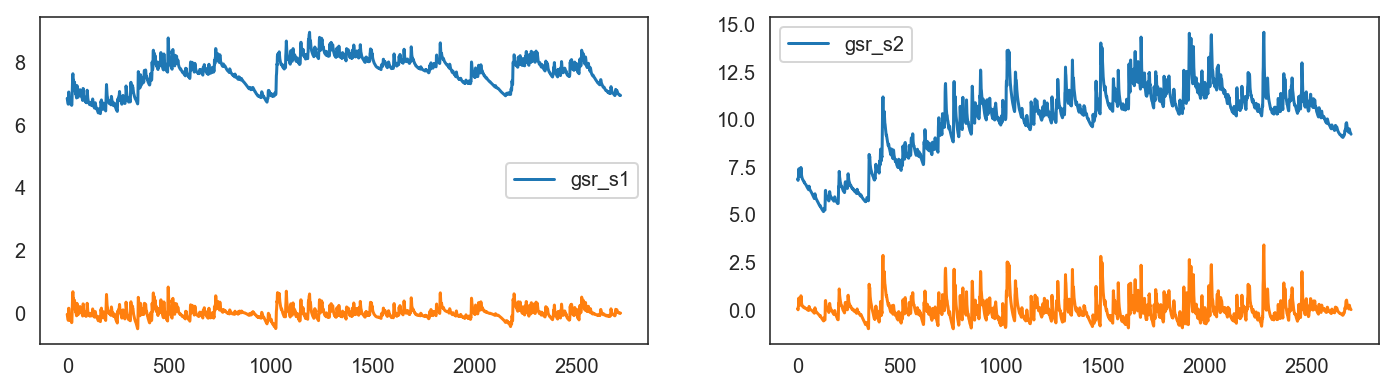

In [140]:
# filter example 
# Load filtered data
epn = 'ep01'
dyad_number = '73' # Change this number to plot other dyads
dyad_gsrs = pd.read_csv(f'../BandpassFilteredData/dyad_gsr_{epn}_bandpass-low005-high10_median_1hz.csv')
dyad_gsr = dyad_gsrs[[dyad_id for dyad_id in dyad_gsrs.columns if dyad_number in dyad_id]]

# Load unfiltered raw data.
fs = 500.
episode_length = {'ep01':2718, 'ep02':2625, 'ep03': 2578, 'ep04': 2564}
f = glob.glob(os.path.join('../RawData/*s' + dyad_number +'*'+epn+'*'))[0]
data = pd.read_csv(f, header=None,index_col=False, 
       names=['gsr_s1','hr_s1','gsr_s2','hr_s2','trig','bpm_s1','resp_s1','bpm_s2','resp_s2'])   
trig_locs = np.where(data['trig'].diff()>0)[0]
if len(trig_locs)>1:
    mv_start = trig_locs[-2]
    mv_end = int(mv_start + fs * episode_length[epn])
    data = data.iloc[mv_start:mv_end,:]
raw_data = nlstats.downsample(data, method='median', sampling_freq=fs, target=1, target_type='hz')

f, axes = plt.subplots(1,2, figsize=(12,3))
raw_data[['gsr_s1']].plot(ax = axes[0])
dyad_gsr.iloc[:,0].plot(ax = axes[0])

raw_data[['gsr_s2']].plot(ax = axes[1])
dyad_gsr.iloc[:,1].plot(ax = axes[1])

# Extract solo data the same way

In [77]:
sublist = ['s'+str(s) for s in np.arange(21,42,1)]
excl_ep3 = ['s42'] # dyads without data for ep3 and 4

epns = ['ep01','ep02','ep03','ep04']
for epn in epns:
    if epn=='ep03':
        sublist = natsorted(list(set(sublist).difference(set(excl_ep3))))
    all_gsr, all_hr, all_subs = pd.DataFrame(), pd.DataFrame(), []
    for sub in tqdm(sublist):    
        filelist = glob.glob(os.path.join('../RawData/' + sub+'*'+epn+'*'))
        for f in filelist: 
            data = pd.read_csv(f,header=None,index_col=False, 
                   names=['gsr_s1','hr_s1','trig','bpm_s1','resp_s1'])
            trig_locs = np.where(data['trig'].diff()>0)[0]
            if len(trig_locs)>1:
                mv_start = trig_locs[-2]
                mv_end = int(mv_start + fs * episode_length[epn])
                data = data.iloc[mv_start:mv_end,:]
                
                fs= 500.0 # recorded at 500hz
                lowcut = .005 # lowcut at .005 hz
                highcut = 10
                data_bandpassed = butter_bandpass_filter(data, lowcut=lowcut, highcut=highcut, fs=fs, order=1)
                ds_data = nlstats.downsample(data_bandpassed, method='median', sampling_freq=500, target=1, target_type='hz')
                assert(ds_data.shape[0]==episode_length[epn])
                
                all_subs.extend( [sub] )
                all_gsr = pd.concat([all_gsr, ds_data[['gsr_s1']]],axis=1)
            else:
                print(['Trigger uncertain: ',f])
    all_gsr.columns = all_subs
    all_gsr.to_csv('../solo_gsr_'+epn+'_bandpass-low005-high10_median_1hz.csv',index=False)

100%|██████████| 21/21 [00:18<00:00,  1.17it/s]


# Load bandpass filtered data, winsorize, and zscore. Also load other dyad metadata

In [2]:
# You need to adjust the path to the data correctly.
def load_bandpass_filtered_data(winsorize=True, zscore=True, method="pearson"):
    """
    Loads the bandpass filtered data, performs winsorizing and standardiziin
    
    Args: 
        winsorize: winsorize the data
        zscore: standardize data
        method: pearson or spearman for calculating synchrony metric.
        
    Returns: 
        dyad_data: dataframe with other metrics.
        detrended_dyad_data: dictionary for each episode with processed timeseries data
    """
    new_df = pd.DataFrame()
    detrended_dyad_data = {}
    epns = ['ep01', 'ep02', 'ep03', 'ep04']
    for epn in epns:
        df_detrended = pd.read_csv(f'../BandpassFilteredData/dyad_gsr_{epn}_bandpass-low005-high10_median_1hz.csv', )

        # winsorize to remove artifacts
        if winsorize:
            df_detrended = df_detrended.apply(lambda x: nlstats.winsorize(x,cutoff={'std':[3,3]}))

        # zscore standardize 
        if zscore:
            df_detrended = df_detrended.apply(stats.zscore)
        detrended_dyad_data[epn] = df_detrended

        group_index = [_gid.split('_')[0] for _gid in df_detrended.columns[::2].values]
        df_corr = pd.DataFrame(parse_triangle(df_detrended.corr(method=method).values, condition='pairs'), index=group_index).reset_index()
        df_corr.columns =["dyadID","GSRsync"]
        df_corr['Episode'] = epn
        new_df = pd.concat([new_df, df_corr],axis=0)

    _dyad_data = pd.read_csv('../../../Analyses/Dyad_Paper/combined_df.csv', index_col=0)
    # dyad_data = _dyad_data.merge(new_df, on=['Episode', 'dyadID'])
    dyad_data = _dyad_data.join(new_df.set_index(['Episode','dyadID']), on=['Episode','dyadID'])
    return dyad_data, detrended_dyad_data


# Plot synchrony for each dyad

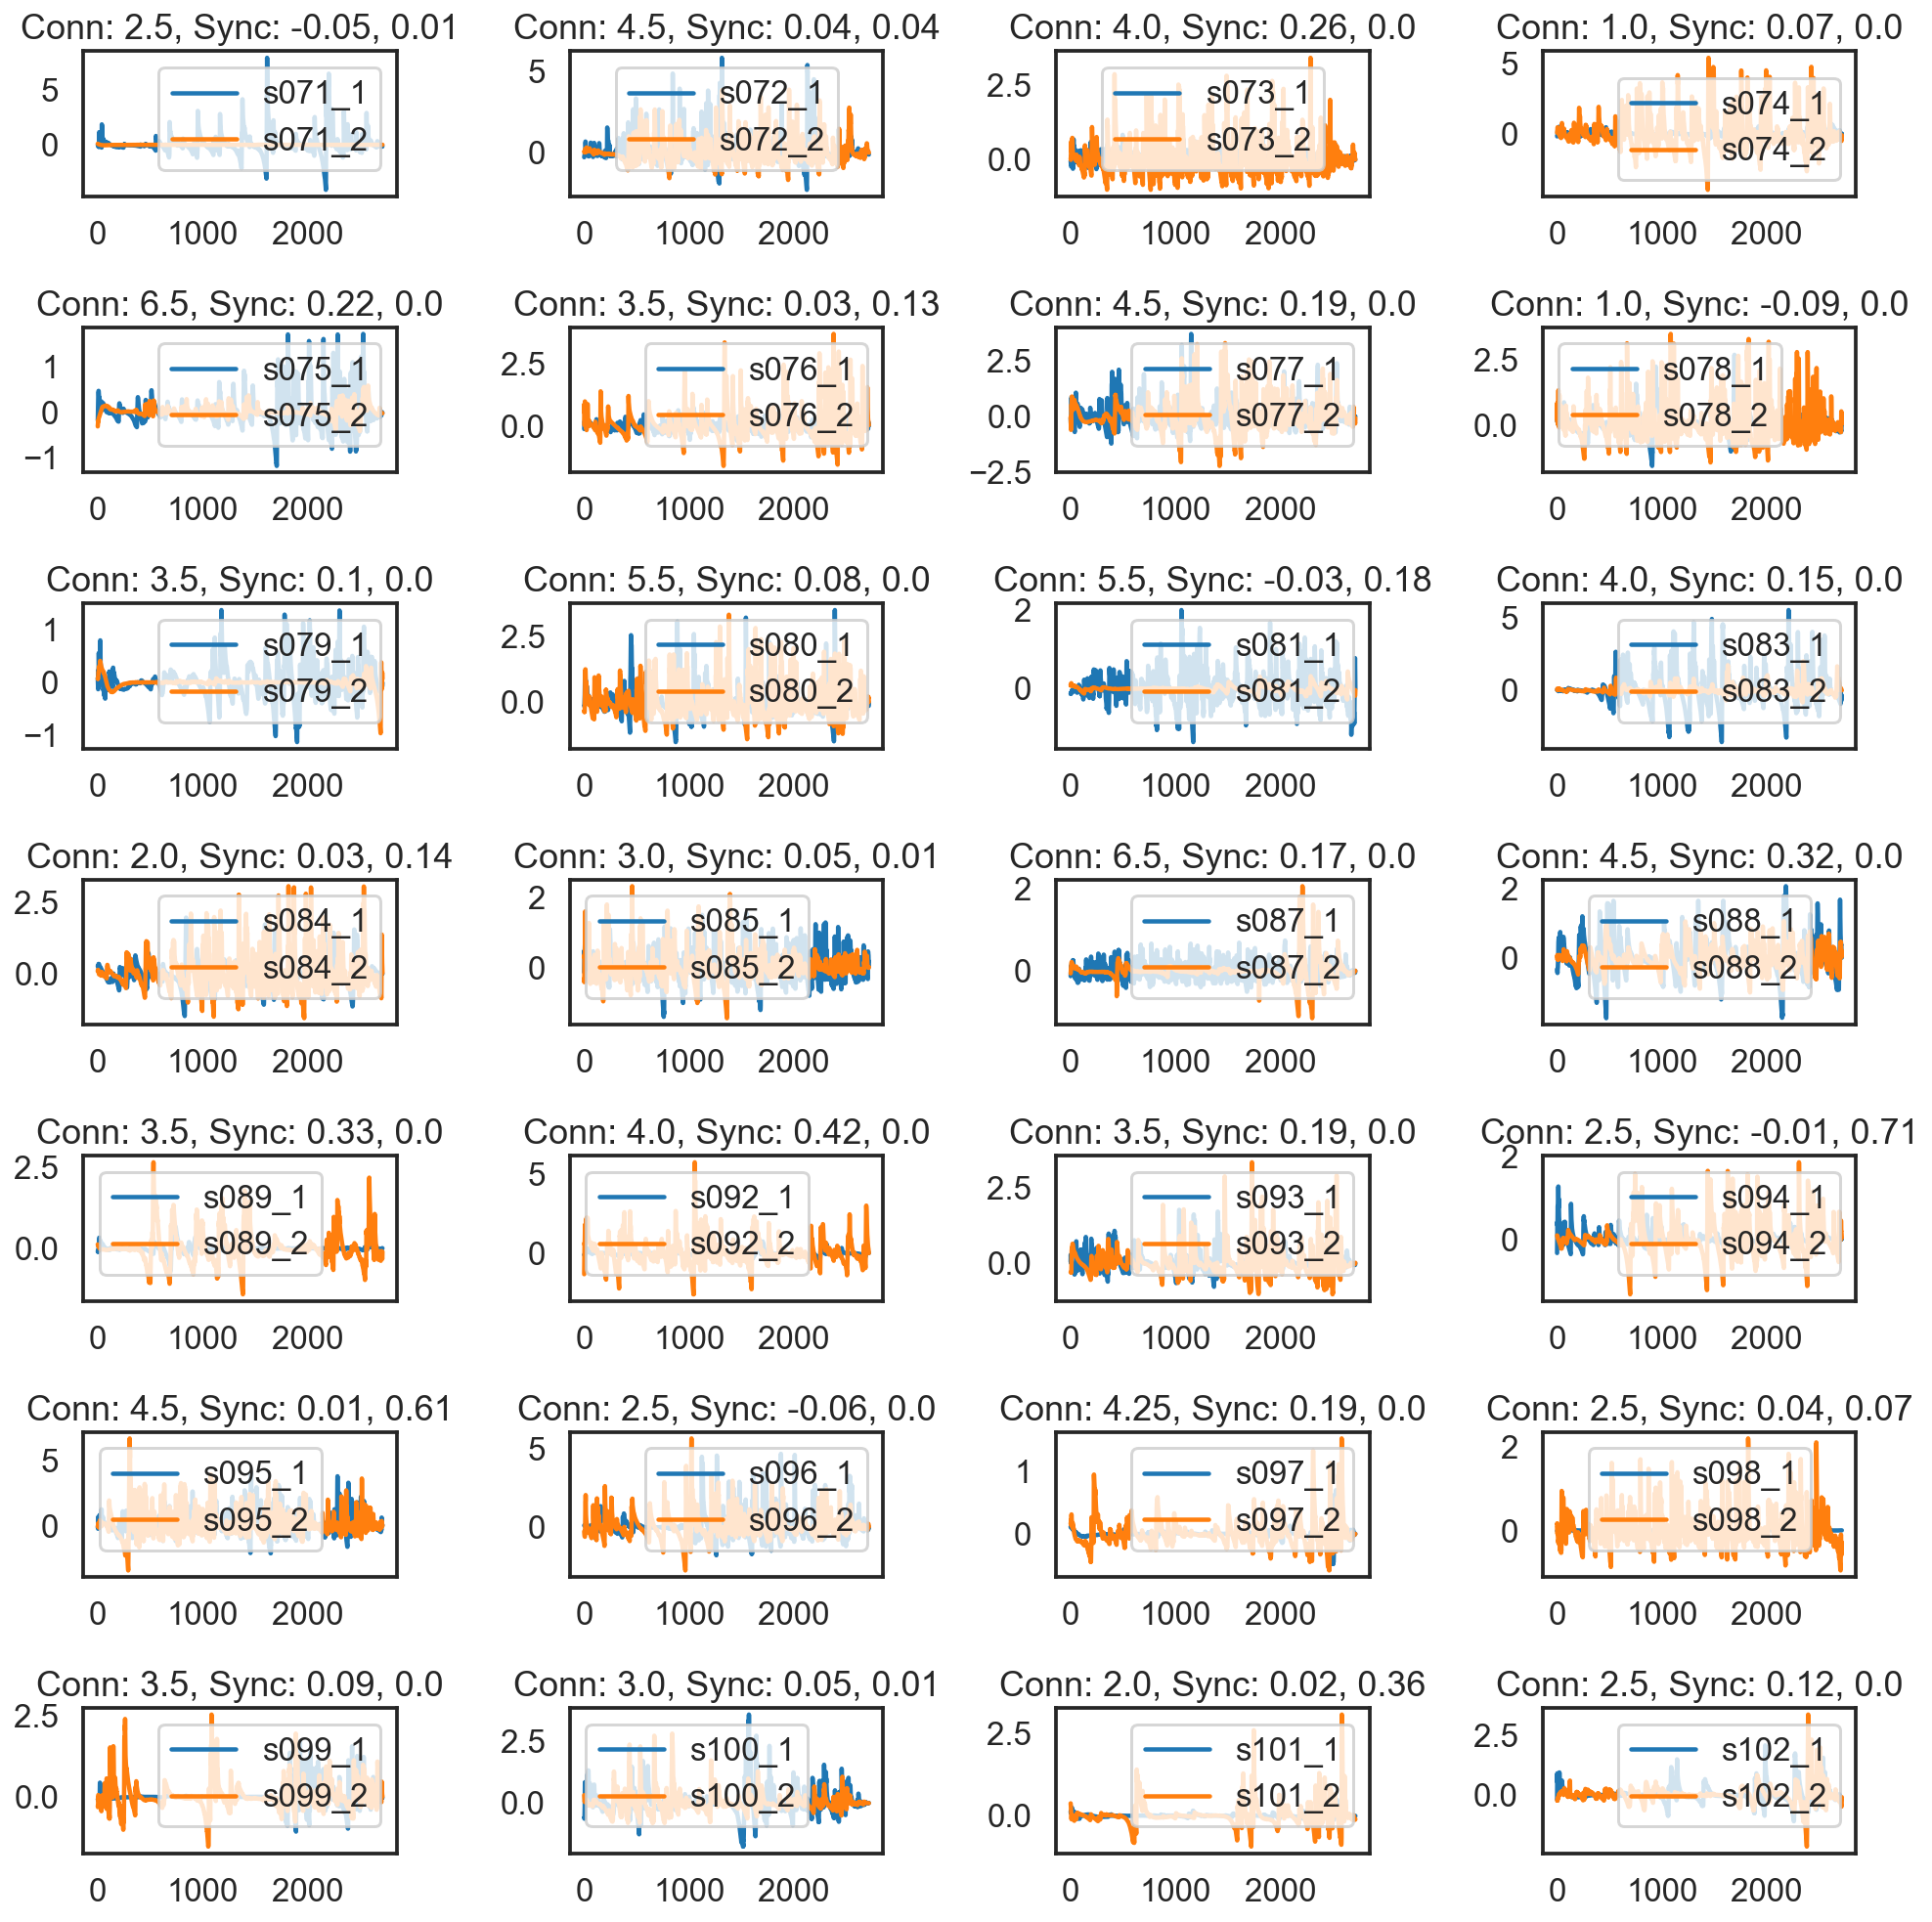

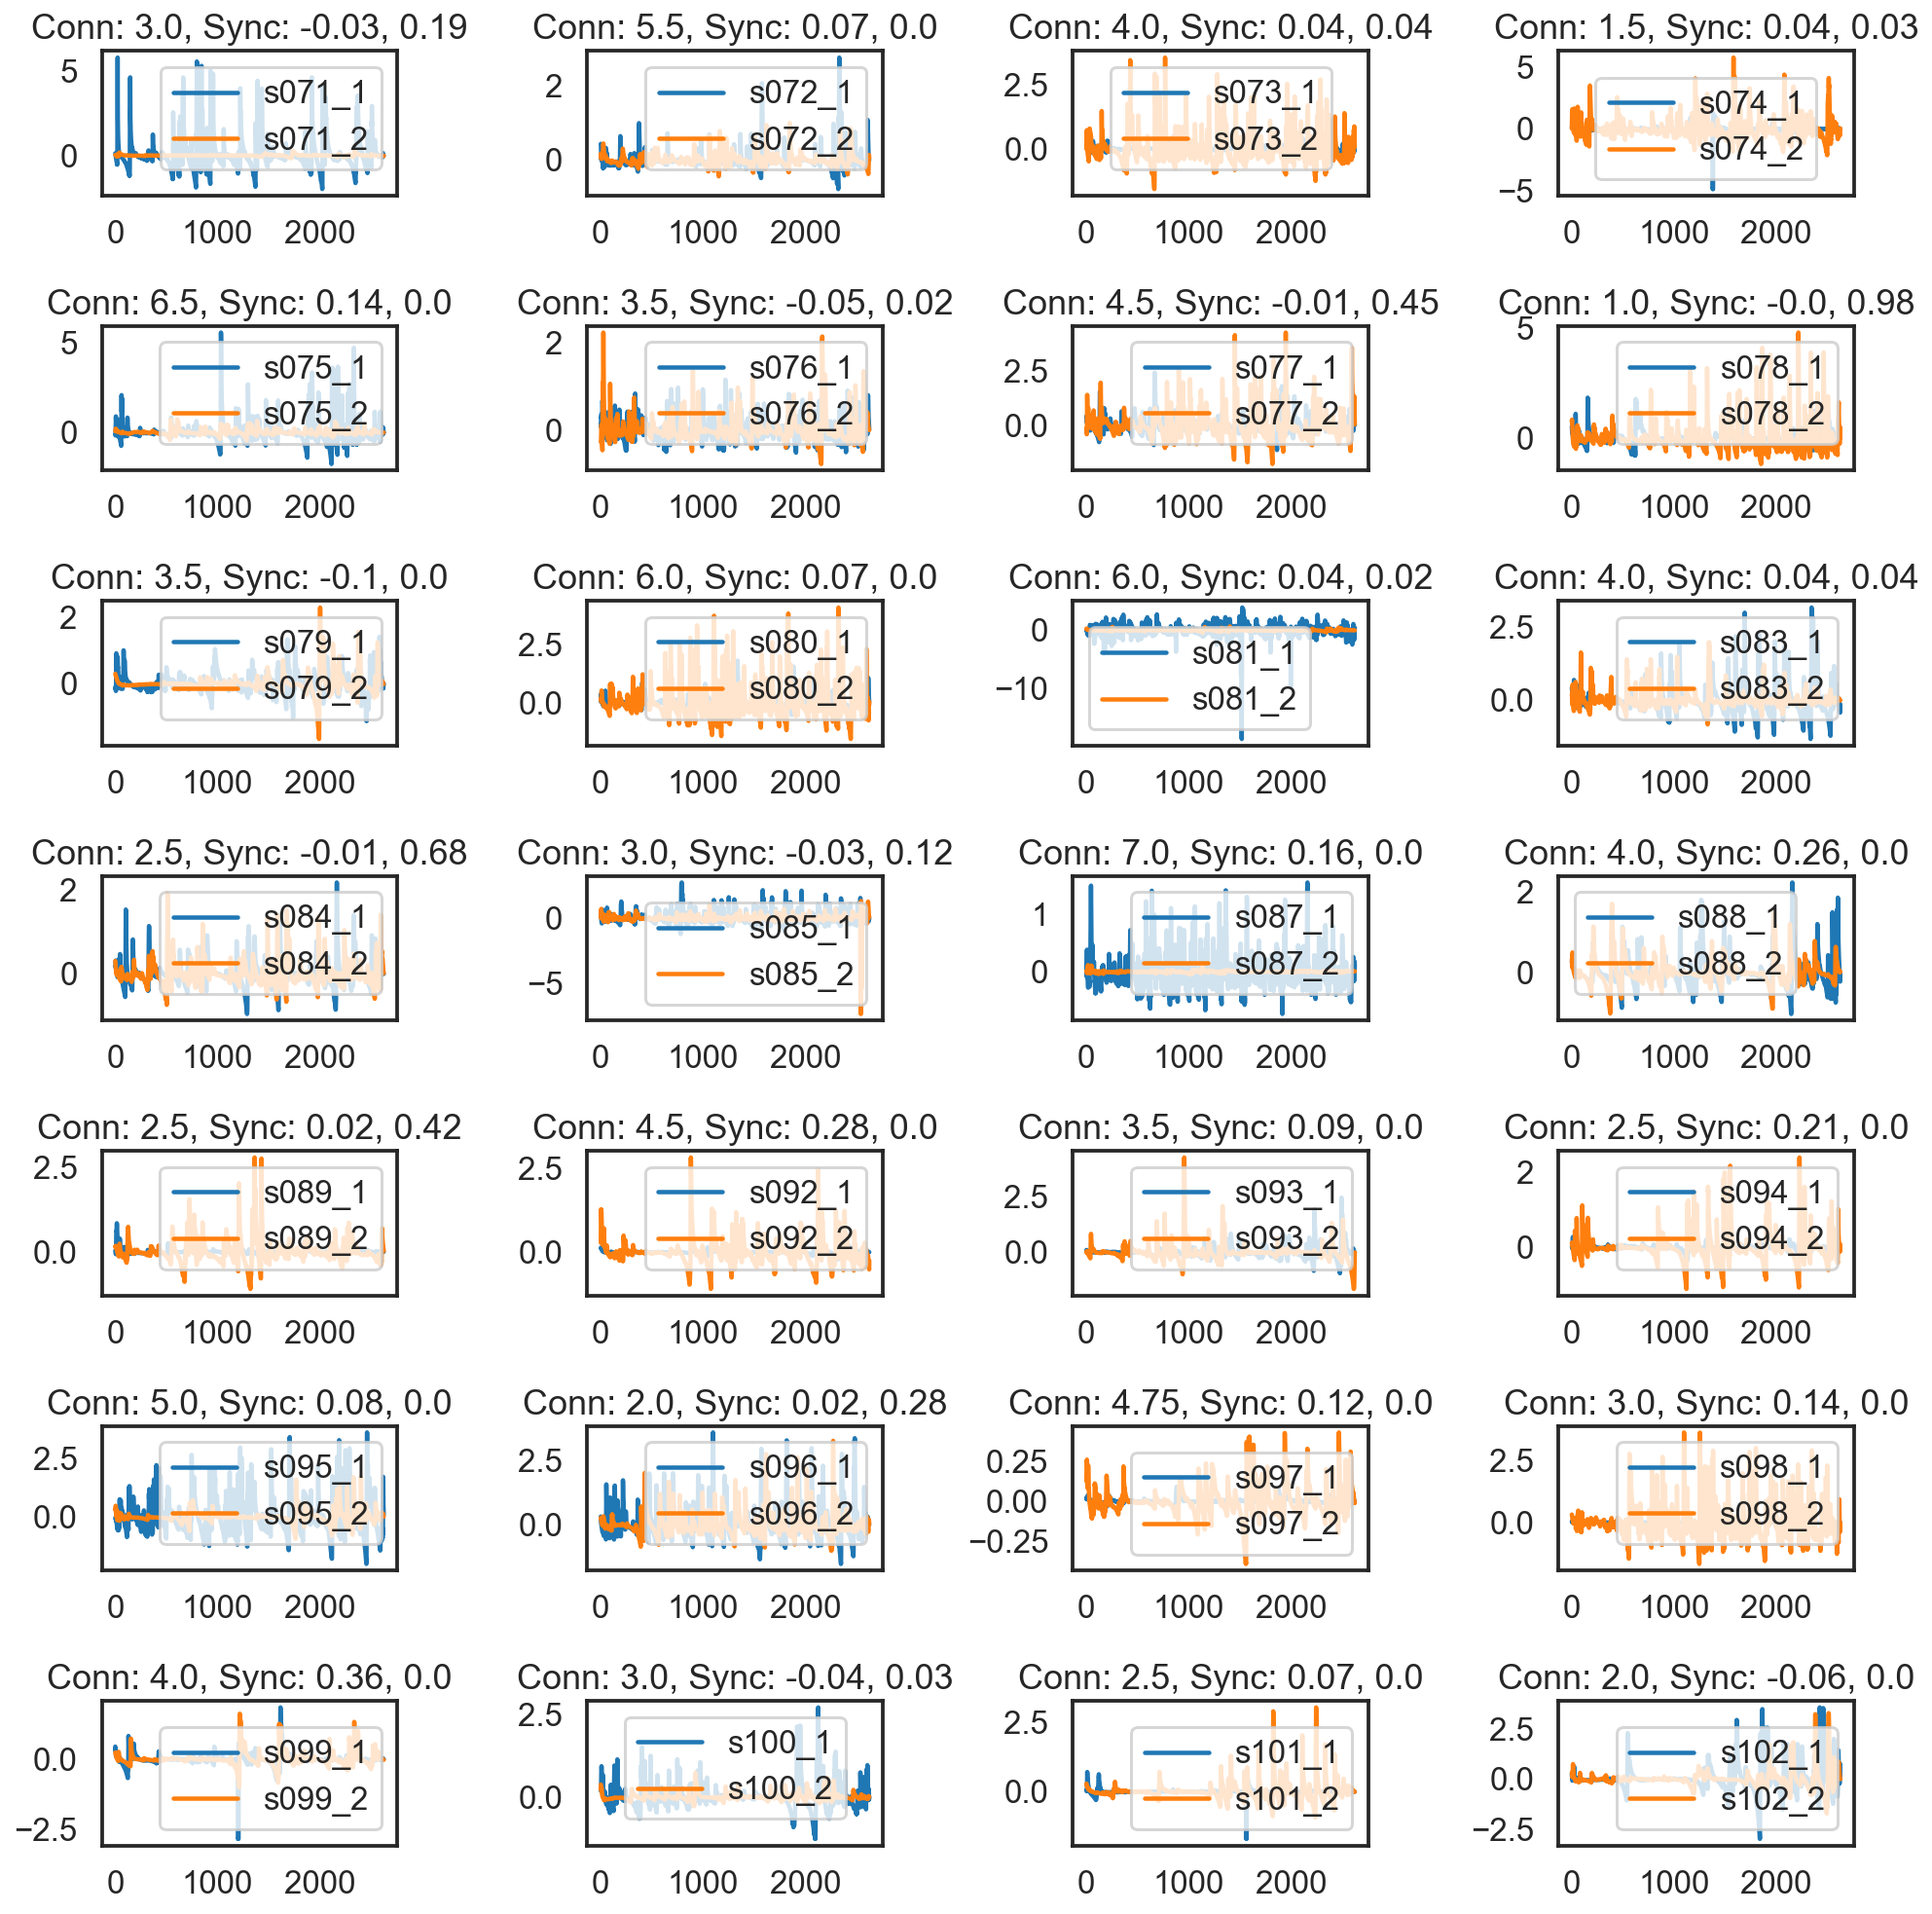

s084 not in ep03


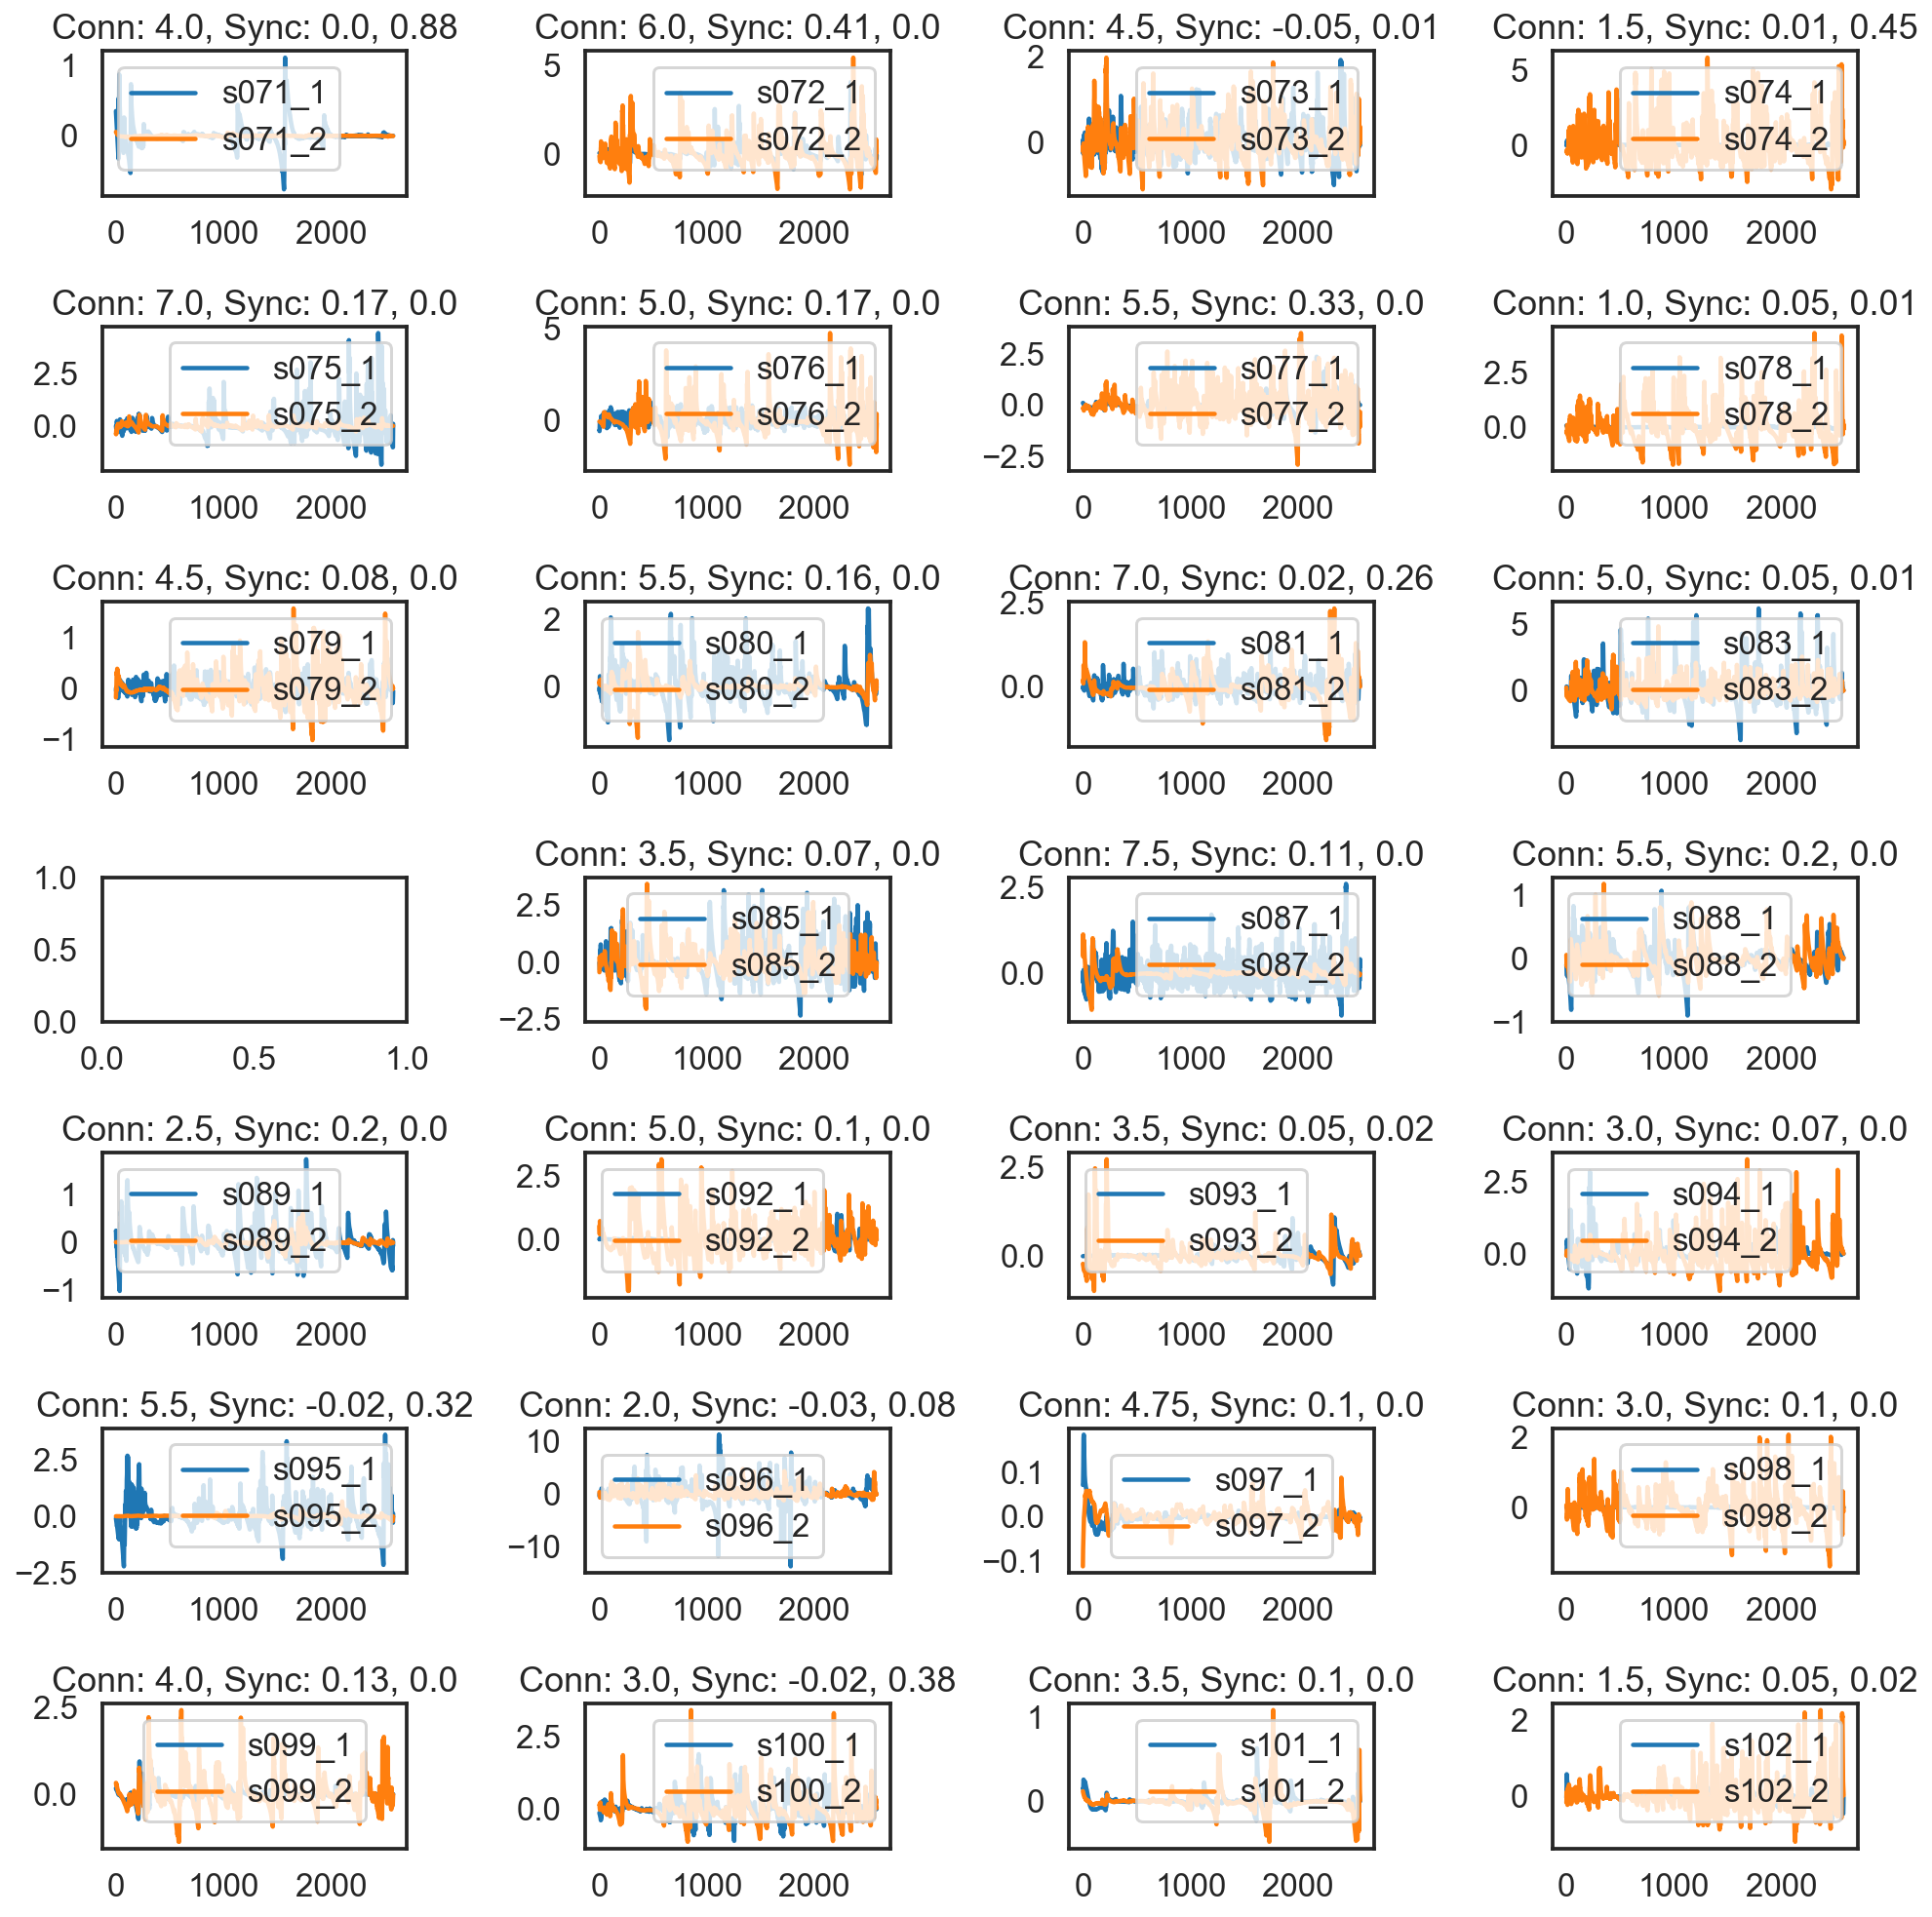

s084 not in ep04


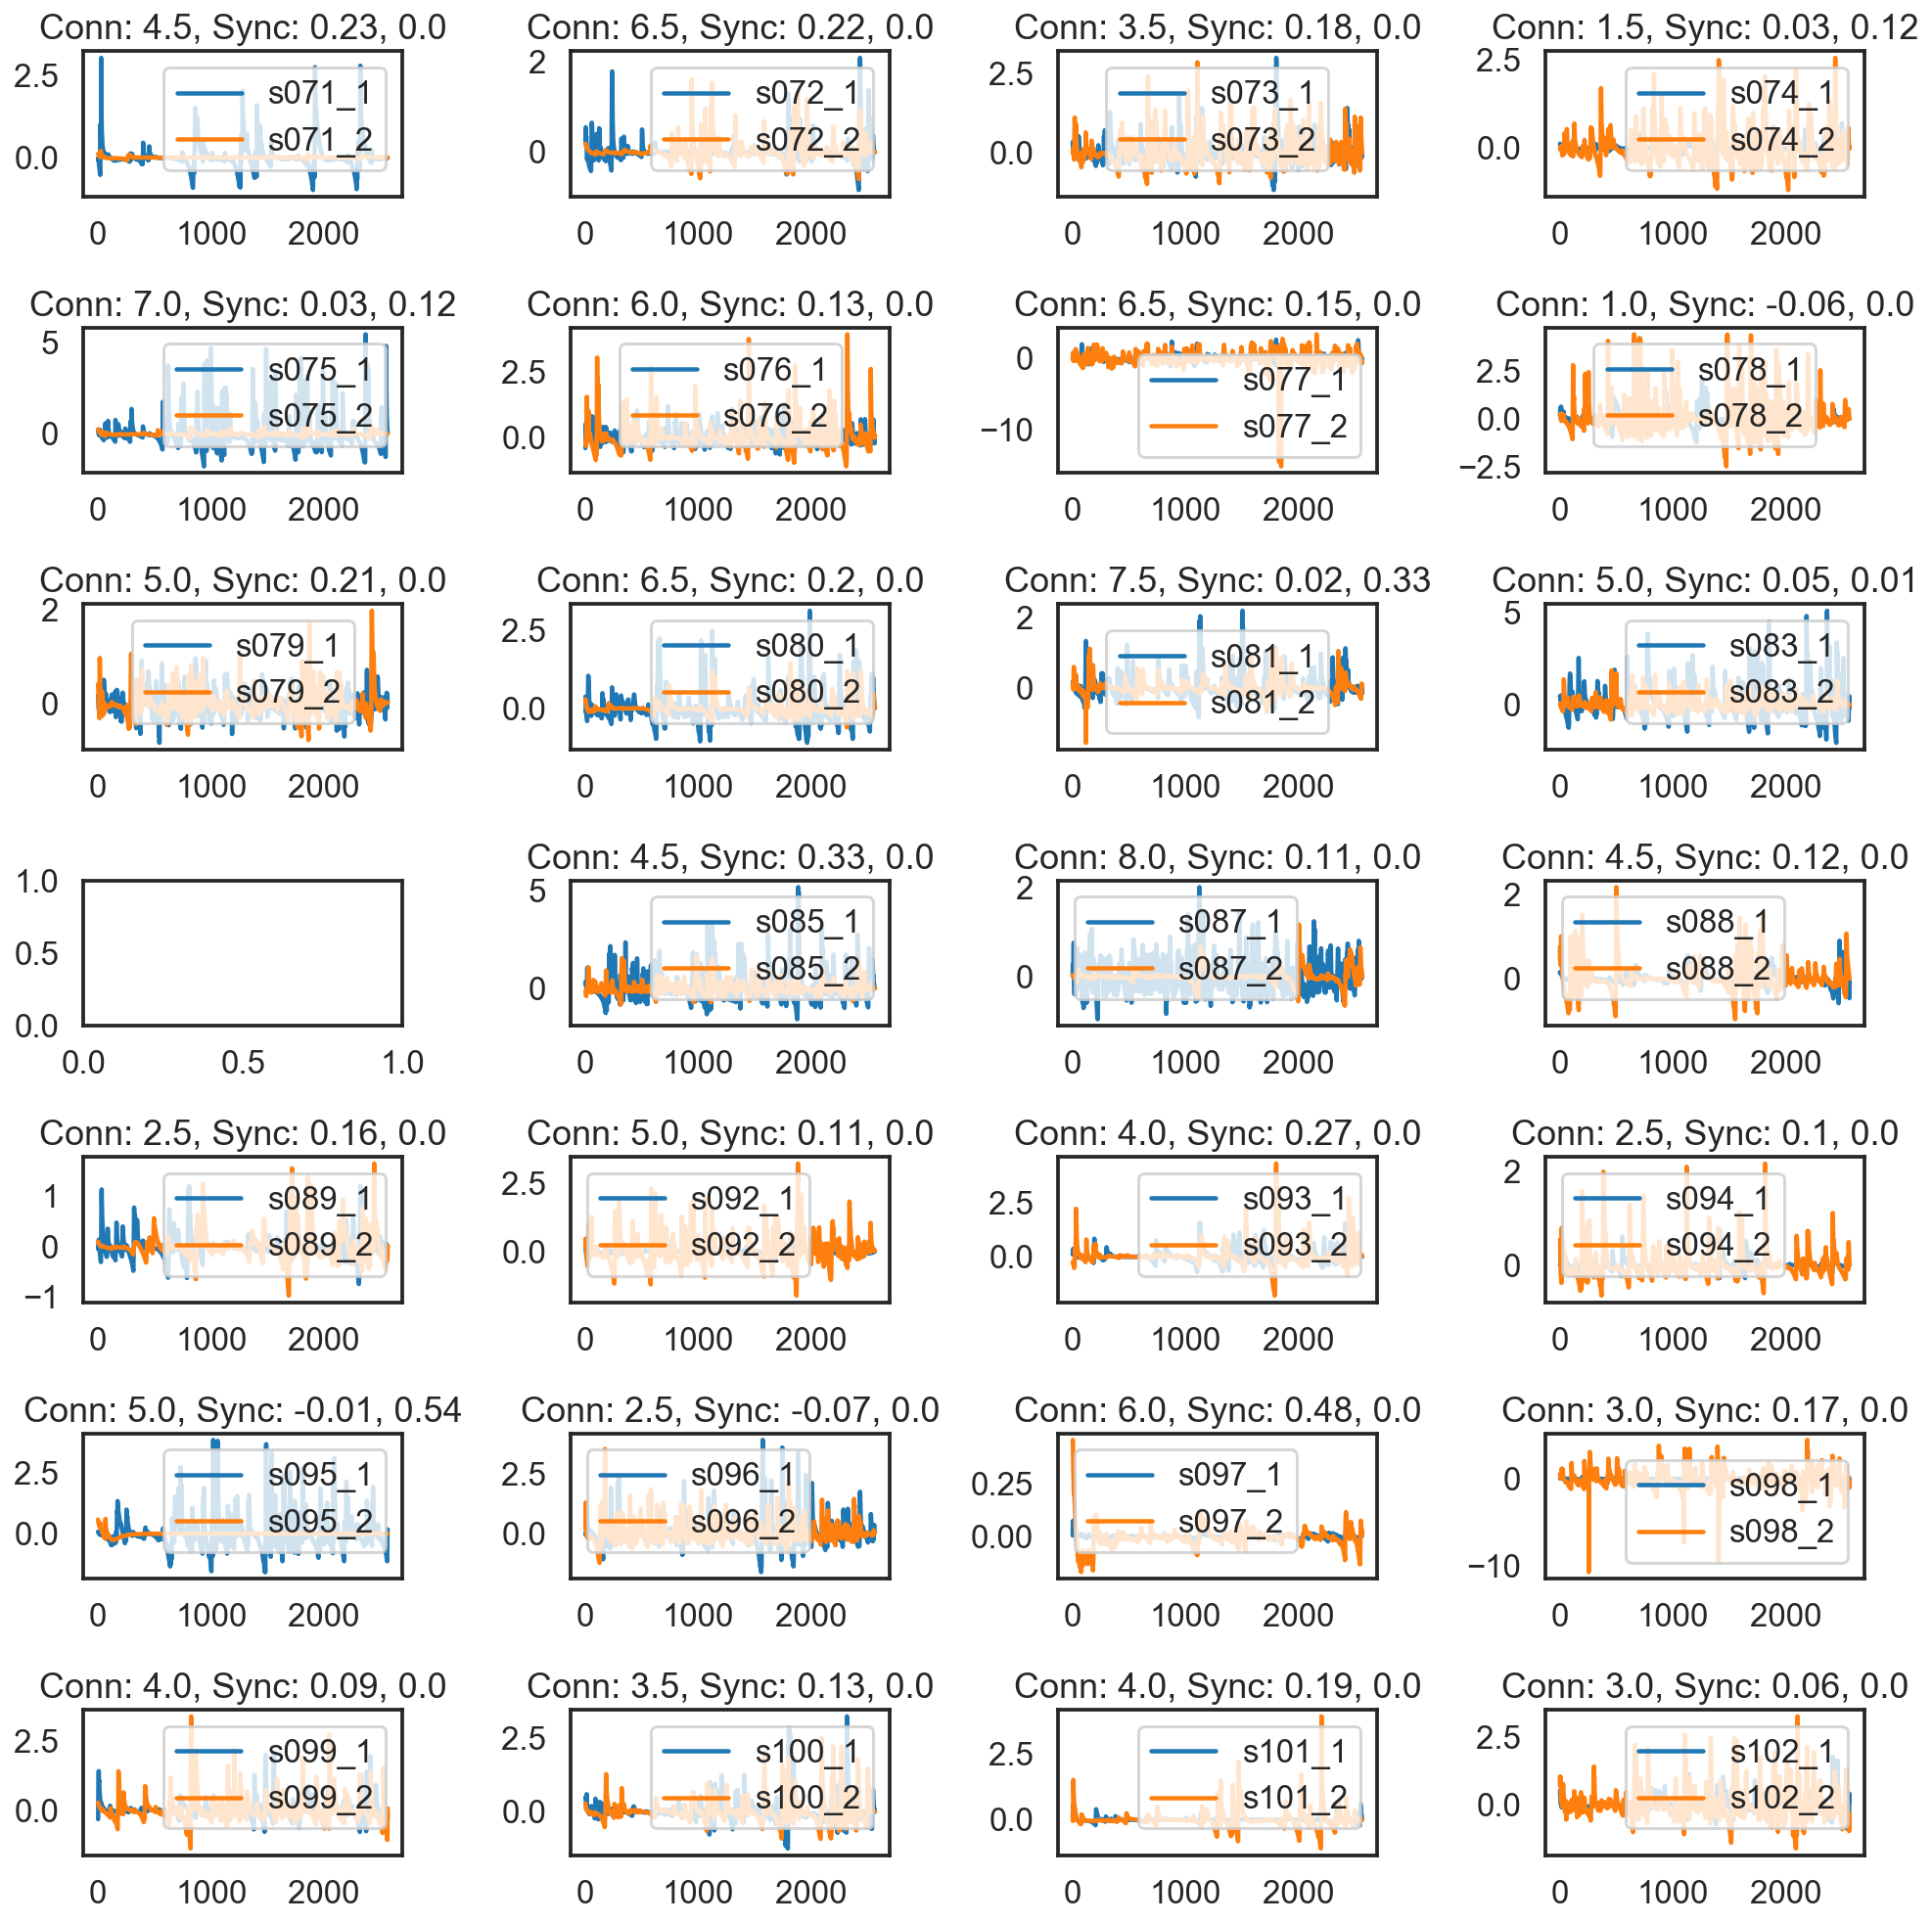

In [4]:
winsorize = False
zscore = False
method = 'pearson'
dyad_data, detrended_dyad_data = load_bandpass_filtered_data(method=method, winsorize=winsorize, zscore=zscore)

sns.set_context('talk')
epns = ['ep01','ep02','ep03','ep04']
for epn in epns:
    df_detrended = detrended_dyad_data[epn]
    dyadlist = dyad_data.query('Episode==@epn').dyadID.unique()
    f, axes = plt.subplots(7, 4, figsize=(14,14))
    axes = axes.flatten()
    for dyadix, dyadID in enumerate(dyadlist): 
        try:
            _df_detrended = df_detrended[[f'{dyadID}_1', f'{dyadID}_2']].dropna()
            r,p = stats.pearsonr(_df_detrended[f'{dyadID}_1'],_df_detrended[f'{dyadID}_2'])
            mc = dyad_data.query('Episode==@epn and dyadID==@dyadID')['mean_Connection'].values[0]
            
            df_detrended[[f'{dyadID}_1', f'{dyadID}_2']].plot(ax=axes[dyadix])
            axes[dyadix].set(title=f'Conn: {mc}, Sync: {np.round(r,2)}, {np.round(p,2)}')
        except:
            print(f"{dyadID} not in {epn}")
    plt.tight_layout()
    plt.show()

# Plot GSR synchrony and other synchrony relations

In [5]:
from fnl_tools.plotting import plot_sync_relations

GSR synchrony metric calculated by Pearson
GSR synchrony metric calculated by Spearman


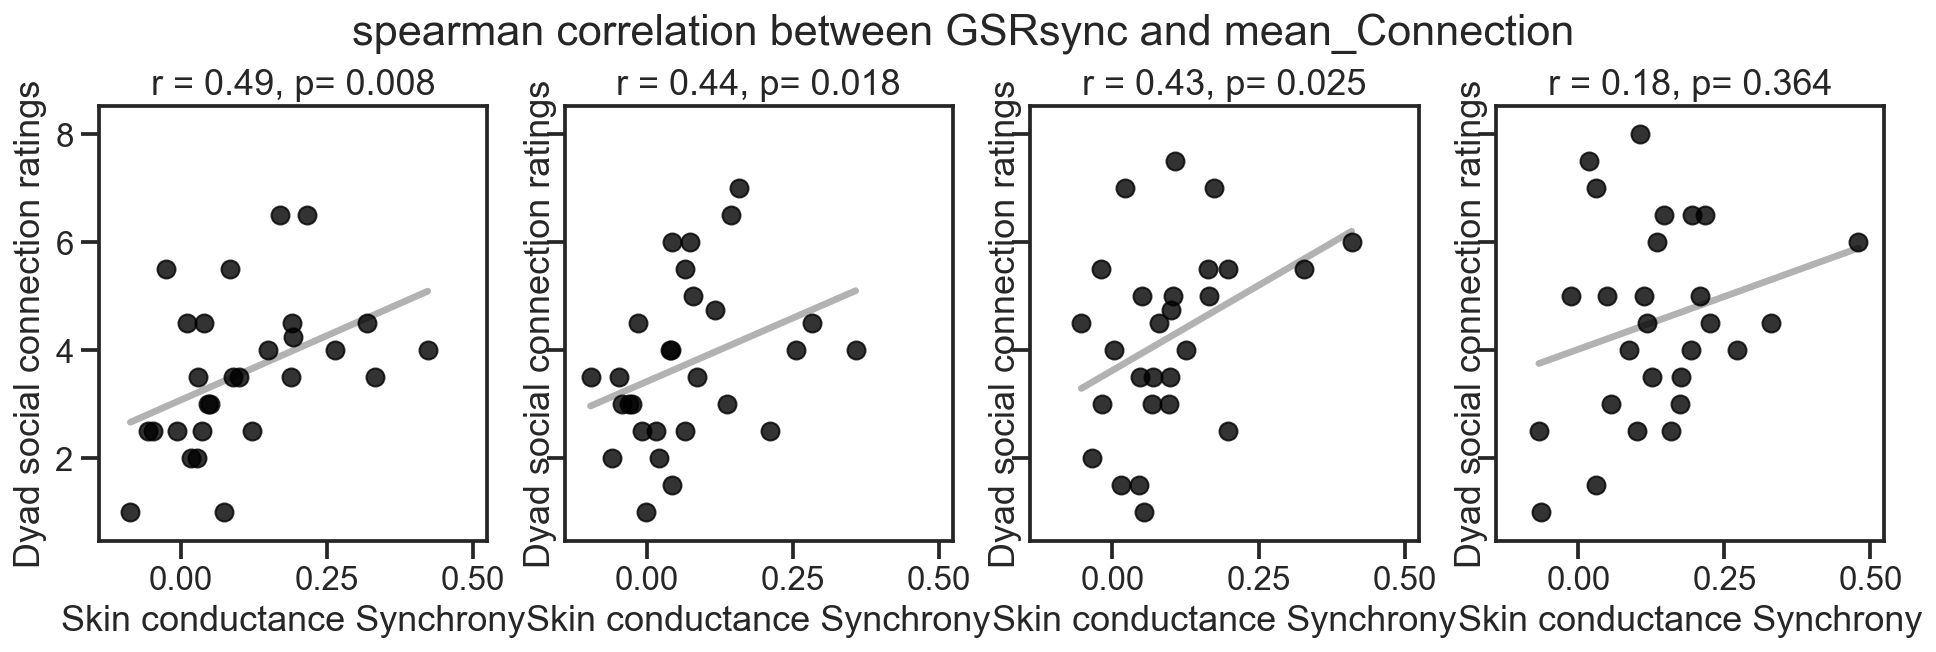

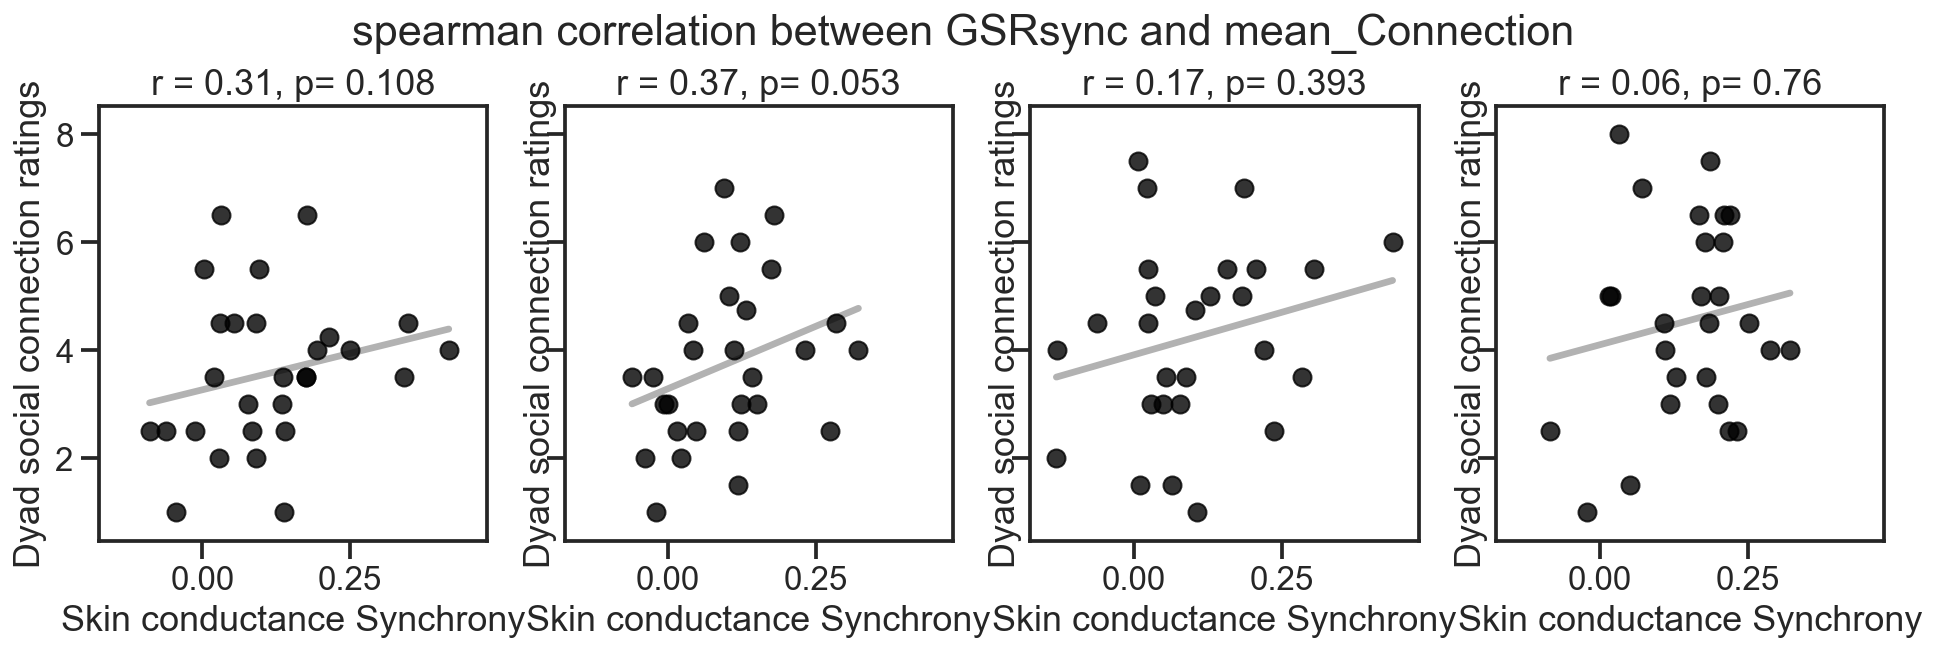

In [20]:
sns.set_context("talk")
print("GSR synchrony metric calculated by Pearson")

winsorize = False
zscore = False
sync_method = 'pearson'
dyad_data, detrended_dyad_data = load_bandpass_filtered_data(method=sync_method, 
                                                             winsorize=winsorize, 
                                                             zscore=zscore)
method = 'spearman'
axes = plot_sync_relations('GSRsync','mean_Connection', 
                           xlabel='Skin conductance Synchrony', 
                           ylabel='Dyad social connection ratings', 
                           method=method, data=dyad_data)


print("GSR synchrony metric calculated by Spearman")
sync_method = 'spearman'
dyad_data, detrended_dyad_data = load_bandpass_filtered_data(method=method, 
                                                             winsorize=winsorize, zscore=zscore)
method = 'spearman'
axes = plot_sync_relations('GSRsync','mean_Connection', 
                           xlabel='Skin conductance Synchrony', 
                           ylabel='Dyad social connection ratings',
                          method=method, data=dyad_data)

ep01 rho :  0.49084257887673594 p :  0.00799875482762658
ep02 rho :  0.44396118763153813 p :  0.01795003405349774
ep03 rho :  0.4308952371087583 p :  0.024841978784421185
ep04 rho :  0.18181997868128758 p :  0.3640592660005554


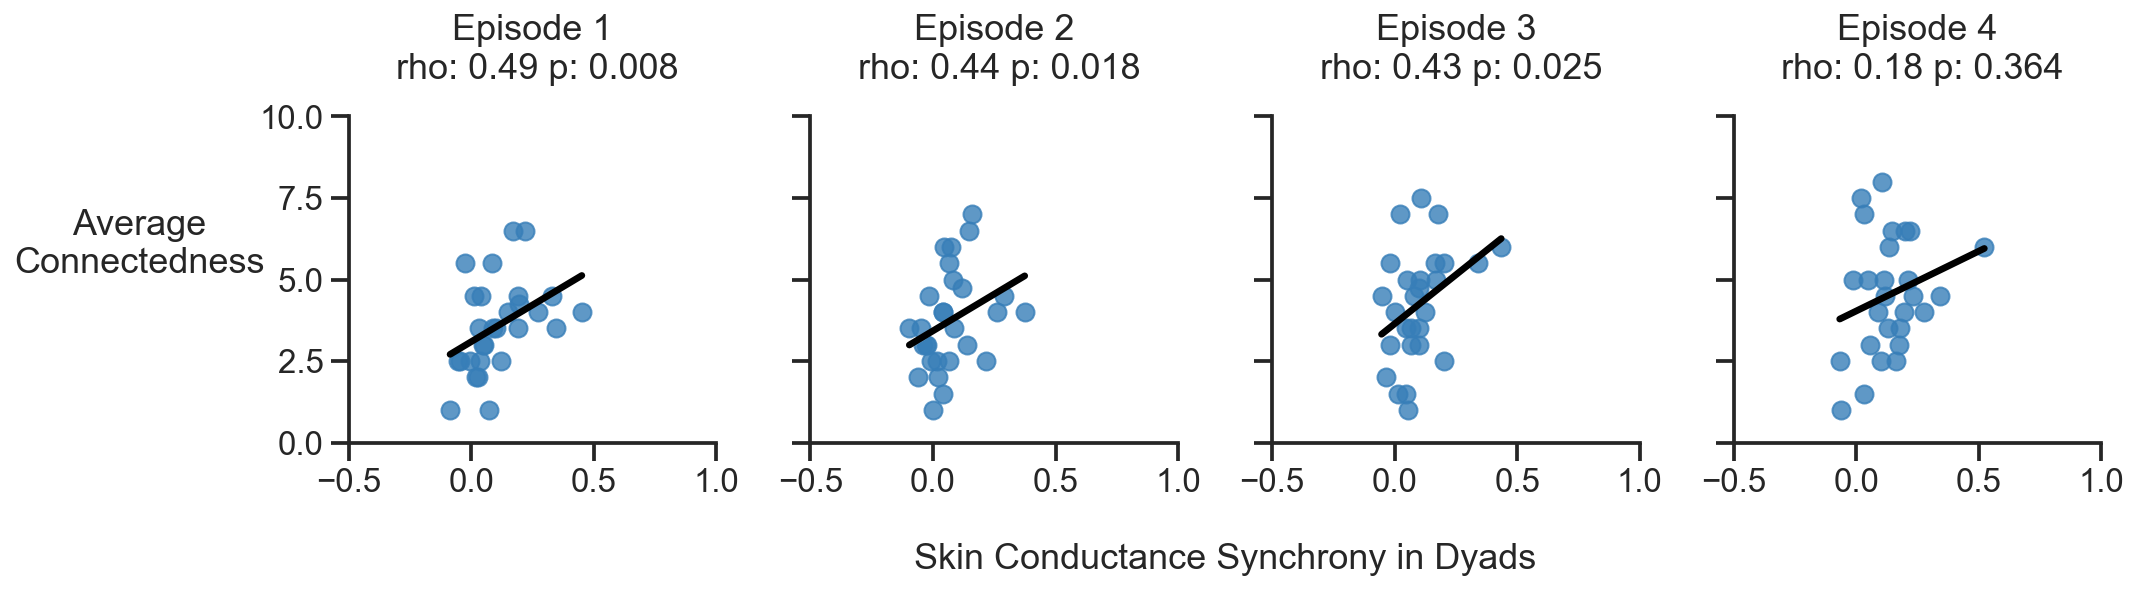

In [12]:
# Connectedness highly correlated with Synchrony.  
winsorize = False
zscore = True
method = 'pearson'
dyad_data, detrended_dyad_data = load_bandpass_filtered_data(method=method, 
                                                             winsorize=winsorize, 
                                                             zscore=zscore)


exclude_friends = False
sns.set_style("ticks")
sns.set_context('talk')
colors = sns.color_palette('Set1')

xname = 'GSRsync'
yname = 'mean_Connection'

epns = ['ep01','ep02','ep03','ep04']
dyad_expressivity, dyadpair_expressivity = [],[]
f,ax = plt.subplots(1,len(epns),figsize=(15,5),sharex=True,sharey=True)
ax[0].set_ylim([0,10])
ax[0].set_xlim([-.5,1])
rdf = pd.DataFrame()
for i, epn in enumerate(epns):
    # Results still hold without friends.
    _data=dyad_data.query('Episode==@epn').dropna()
    dyadcorr = _data[xname]
    dyadcorr = nlstats.fisher_r_to_z(dyadcorr)
    dyadconn = _data[yname]
    r, p = stats.spearmanr(dyadconn, dyadcorr)
    print(epn, 'rho : ',r,'p : ',p)
    ax[i].set_title(f"Episode {i+1}"+'\n rho: '+ str(np.round(r,2))  +' p: ' + str(np.round(p,3)),y=1.08)
    sns.regplot(y = dyadconn.values,x = dyadcorr,ax=ax[i],color='k',ci=False,truncate=True,scatter_kws={'color':colors[1]})
    ax[i].set(xlabel='')

ax[0].set_ylabel('Average\nConnectedness',rotation=0,labelpad=60)
# for common label
f.add_subplot(111, frameon=False)
# plt.tick_params(which='both',labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.grid(False)
plt.xlabel(f'Skin Conductance Synchrony in Dyads',rotation=0,labelpad=50)
sns.despine()
plt.tight_layout()
# f.savefig('Figures/Synchrony_corr_connectedness.pdf',dpi=300)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12a37e400>,
      dtype=object)

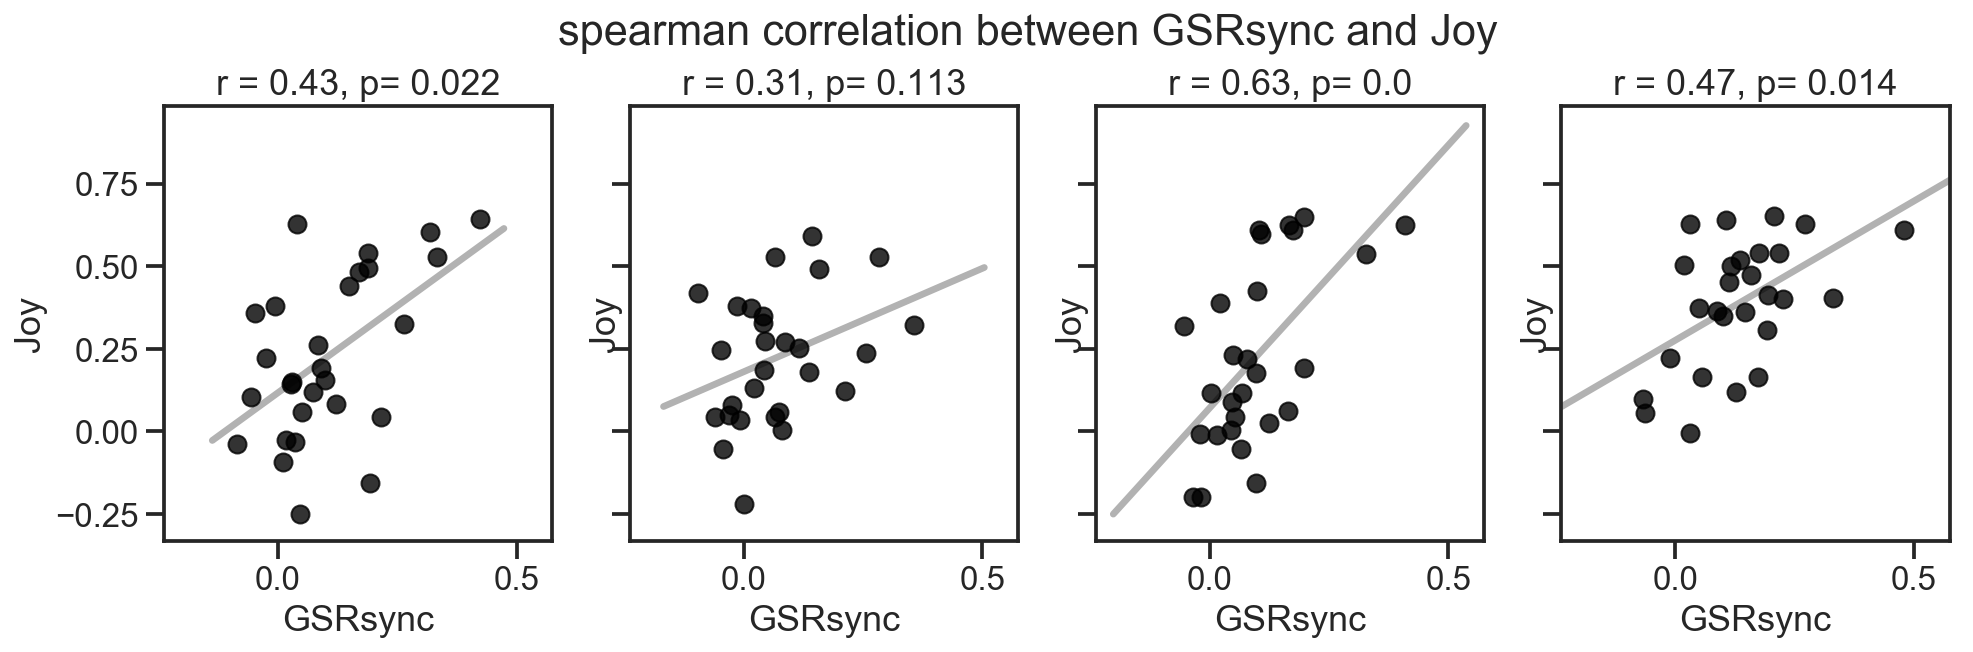

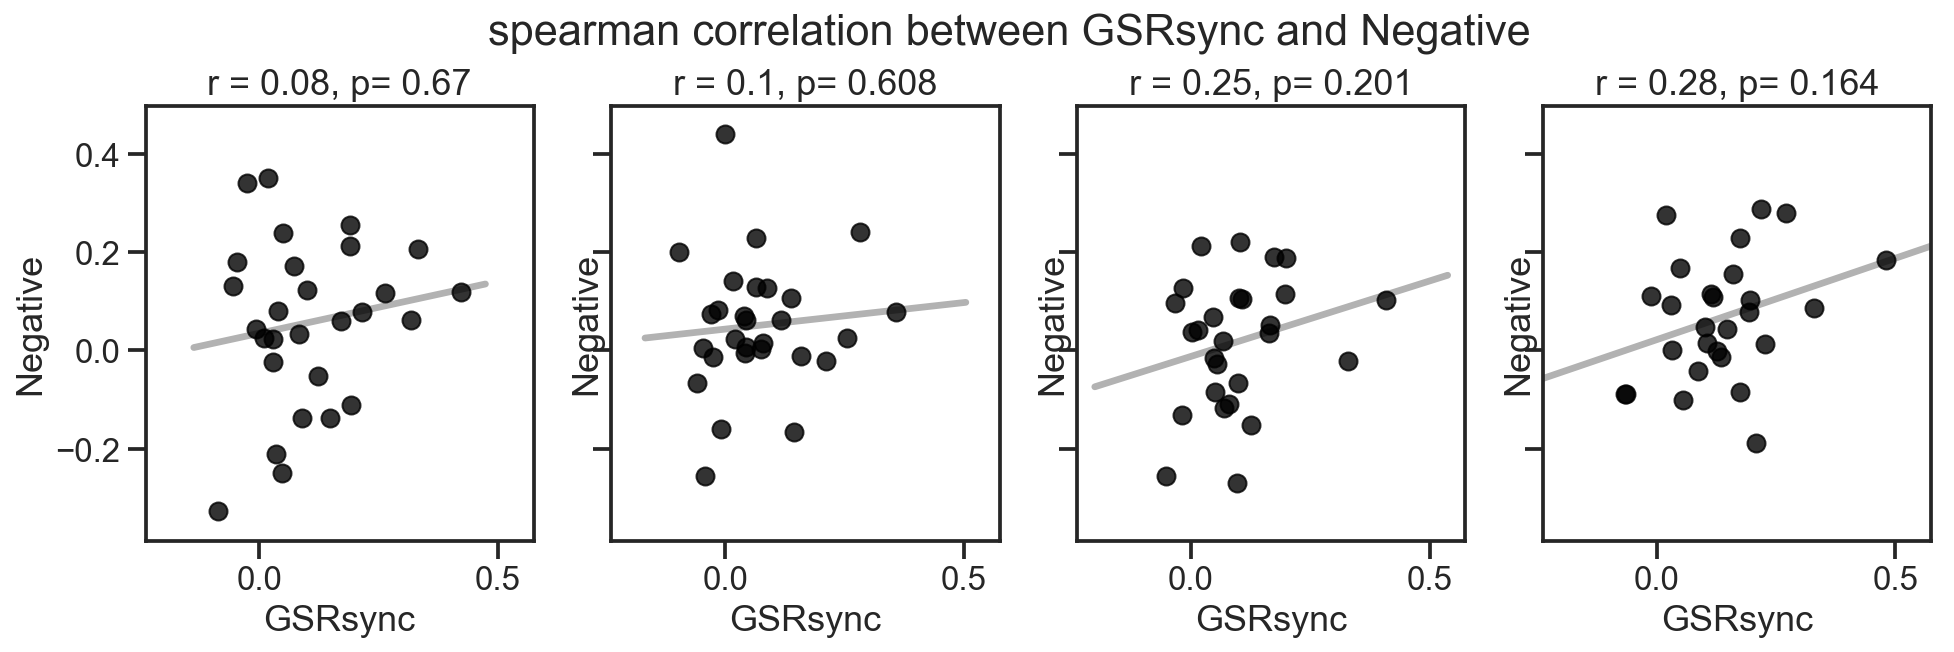

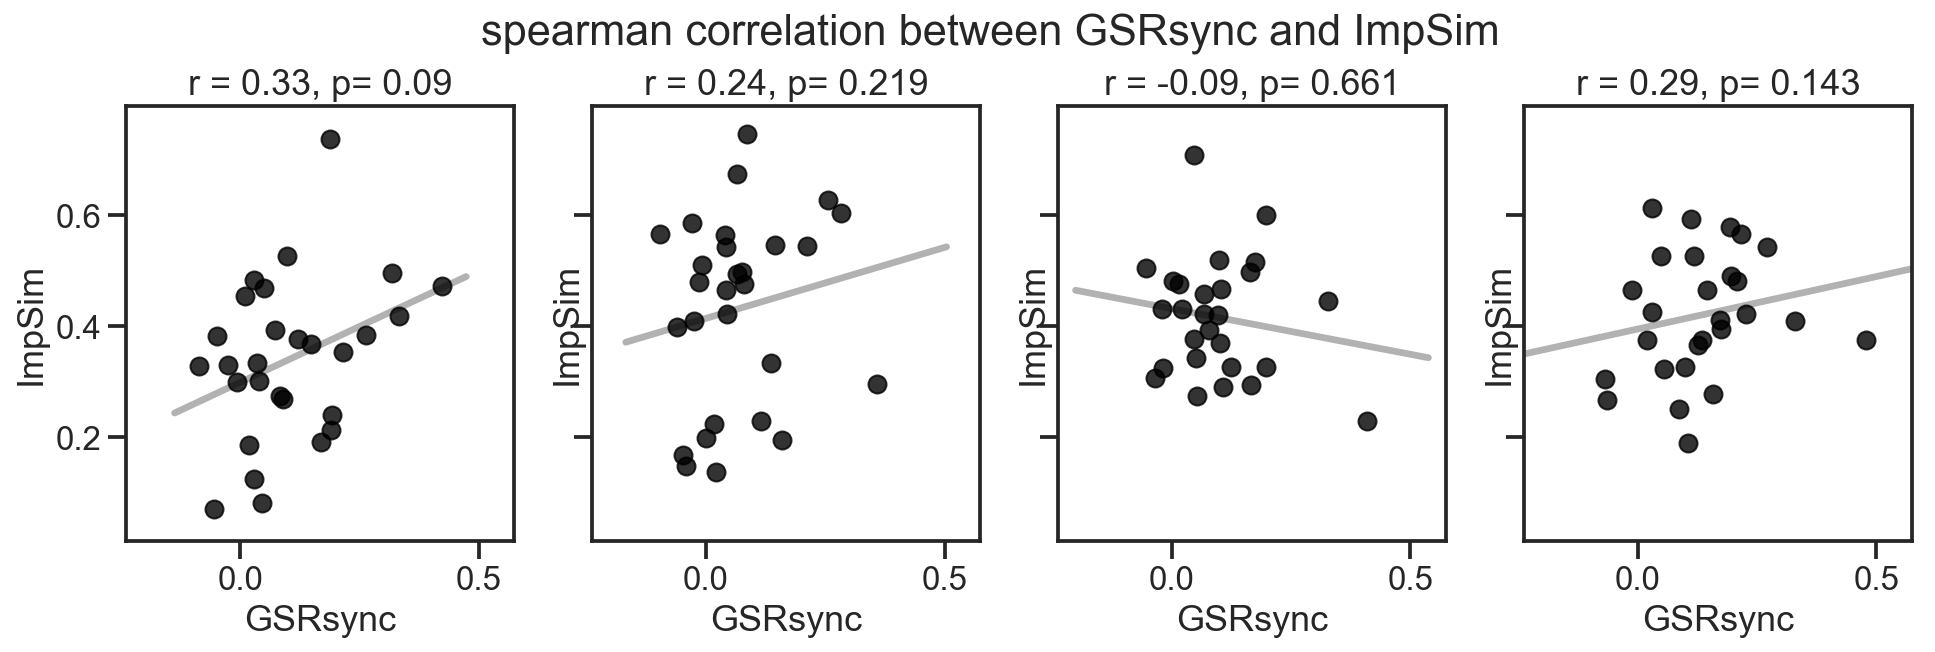

In [128]:
#s84 gsr was not collected properly
plot_sync_relations('GSRsync','Joy', xlabel='GSRsync', ylabel='Joy', data=dyad_data, method='spearman')
plot_sync_relations('GSRsync','Negative', xlabel='GSRsync', ylabel='Negative', data=dyad_data, method='spearman')
plot_sync_relations('GSRsync','ImpSim', xlabel='GSRsync', ylabel='ImpSim', data=dyad_data, method='spearman')

# Compare solo vs dyad for GSR


In [132]:
# Make sure to adjust the path to the filtered data.
def load_solo_and_dyad_ts_sync(method, winsorize, zscore): 
    """
    Load solo and dyad data and calculate synchrony based on "method" and return dataframe with solo, dyads, and nonpairs
    
    Args: 
        method: pearson or spearman used for correlation
        winsorize:
        zscore: 
        
    Return: 
        rdf: dataframe with all synchrony by condition
    """
    dyad_r_df, solo_r_df = {},{}
    epns =  ['ep01', 'ep02', 'ep03', 'ep04']
    for epn in epns:
        # Load solo data
        df_detrended = pd.read_csv(f'../BandpassFilteredData/solo_gsr_{epn}_bandpass-low005-high10_median_1hz.csv', )
        # winsorize to remove artifacts
        if winsorize:
            df_detrended = df_detrended.apply(lambda x: nlstats.winsorize(x,cutoff={'std':[3,3]}))
        # zscore standardize 
        if zscore:
            df_detrended = df_detrended.apply(stats.zscore)
        solo_r_df[epn] = df_detrended.copy()

        # Load dyad data
        df_detrended = pd.read_csv(f'../BandpassFilteredData/dyad_gsr_{epn}_bandpass-low005-high10_median_1hz.csv', )
        # winsorize to remove artifacts
        if winsorize:
            df_detrended = df_detrended.apply(lambda x: nlstats.winsorize(x,cutoff={'std':[3,3]}))
        # zscore standardize 
        if zscore:
            df_detrended = df_detrended.apply(stats.zscore)
        dyad_r_df[epn] = df_detrended.copy()

    rdf = pd.DataFrame()
    for epi, epn in enumerate(epns):
        _corr = solo_r_df[epn].corr(method = method)
        sub1, sub2 = grab_subIDs(_corr)
        rdf = pd.concat([rdf, pd.DataFrame({'Episode': epn, 'Condition': 'Alone', 'Sub1':sub1, 'Sub2':sub2,
                                            'Synchrony': parse_triangle(_corr.values,condition='upper')})])
        # dyad pairs
        _corr = dyad_r_df[epn].corr(method = method)
        sub1, sub2 = _corr.index[::2], _corr.index[1::2]
        
        rdf = pd.concat([rdf, pd.DataFrame({'Episode': epn,'Condition': 'Dyad', 'Sub1':sub1, 'Sub2':sub2,
                                            'Synchrony': parse_triangle(_corr.values,condition='pairs')})])
        #dyad nonpairs
        sub1 = parse_triangle(_corr.apply(lambda x: x.index).values,condition='nonpairs')
        sub2 = parse_triangle(_corr.apply(lambda x: x.index).T.values,condition='nonpairs')
        rdf = pd.concat([rdf, pd.DataFrame({'Episode': epn,'Condition': 'DyadNP', 'Sub1':sub1, 'Sub2':sub2,
                                            'Synchrony': parse_triangle(_corr.values,condition='nonpairs')})])
    return rdf, solo_r_df, dyad_r_df

pearson


(0, 0.2)

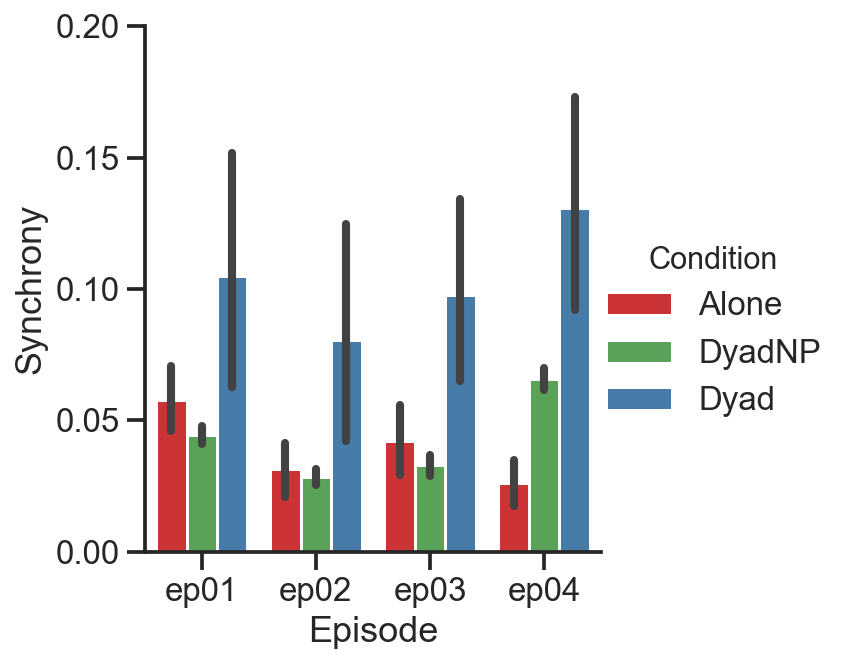

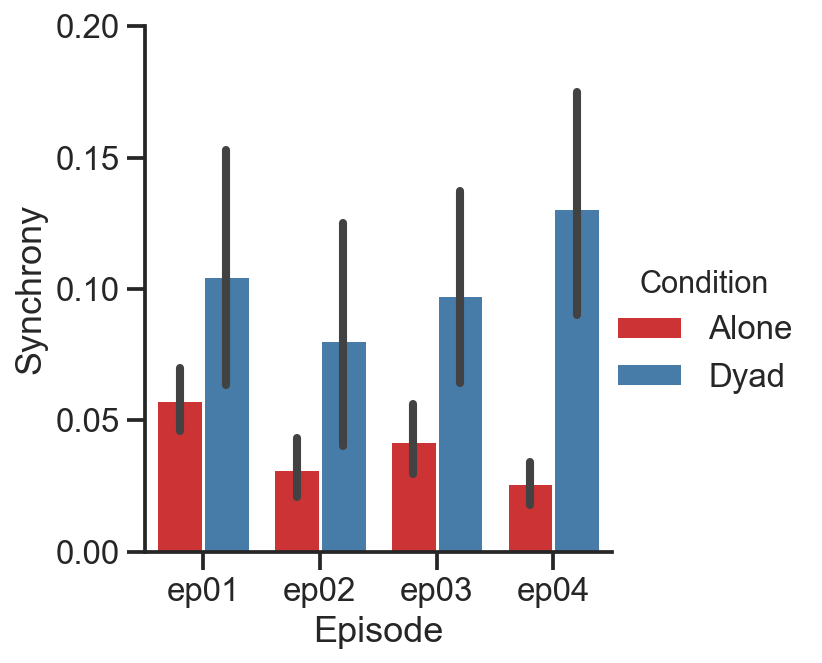

In [134]:
# Set plotting colors
sns.set_palette('Set1')
colors = sns.color_palette('Set1')
solocolor = colors[0] # red
dyadcolor = colors[1] # blue
nonpaircolor = colors[2] # nonpairs

method = 'pearson'
winsorize=False
zscore=True
rdf, solo_r_df, dyad_r_df = load_solo_and_dyad_ts_sync(method = method, winsorize=winsorize, zscore=zscore)
# Figure 1.
print(method)
sns.catplot(x='Episode',y='Synchrony',hue='Condition',hue_order=['Alone','DyadNP','Dyad'],
            data=rdf,ci=95,kind='bar', palette=[solocolor,nonpaircolor,dyadcolor])
plt.ylim([0,.2])

sns.catplot(x='Episode',y='Synchrony',hue='Condition',hue_order=['Alone','Dyad'],
            data=rdf,ci=95,kind='bar', palette=[solocolor,dyadcolor])
plt.ylim([0,.2])

In [ ]:
method = 'spearman'
winsorize=False
zscore=True
rdf, solo_r_df, dyad_r_df = load_solo_and_dyad_ts_sync(method = method, winsorize=winsorize, zscore=zscore)

# Figure 1.
print(method)
sns.catplot(x='Episode',y='Synchrony',hue='Condition',hue_order=['Alone','DyadNP','Dyad'],
            data=rdf,ci=95,kind='bar', palette=[solocolor,nonpaircolor,dyadcolor])
plt.ylim([0,.2])

sns.catplot(x='Episode',y='Synchrony',hue='Condition',hue_order=['Alone','Dyad'],
            data=rdf,ci=95,kind='bar', palette=[solocolor,dyadcolor])
plt.ylim([0,.2])

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


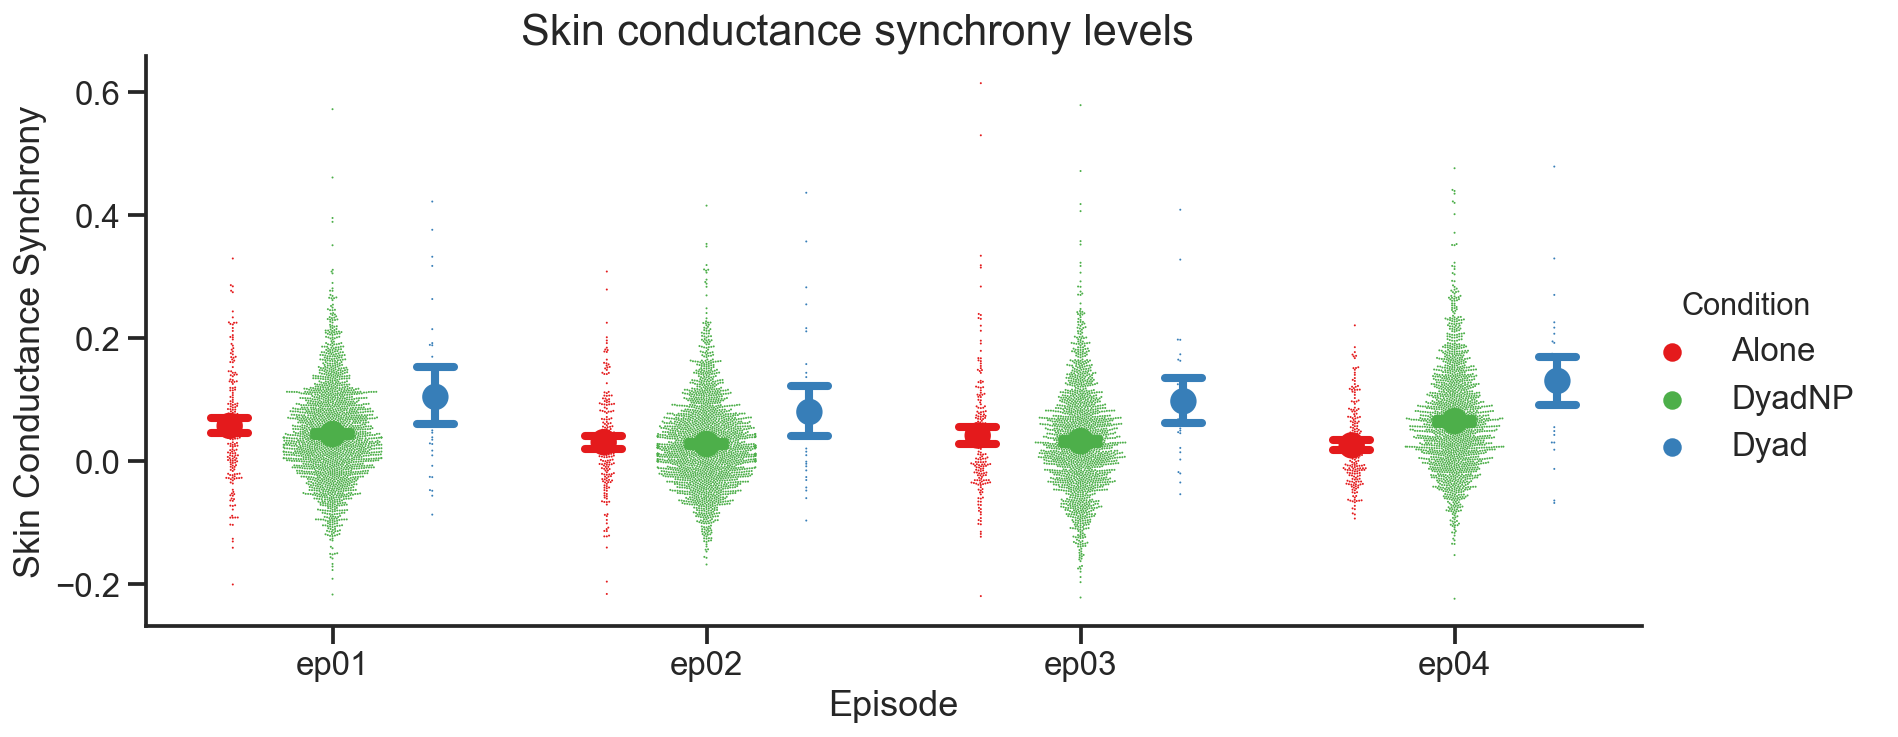

In [135]:
method = 'pearson'
winsorize=False
zscore=True
rdf, solo_r_df, dyad_r_df = load_solo_and_dyad_ts_sync(method = method, winsorize=winsorize, zscore=zscore)
g = sns.factorplot(x='Episode',y='Synchrony',hue='Condition',hue_order=['Alone','DyadNP','Dyad'],
            data=rdf,ci=95,kind='swarm', dodge=1.4,s=1, c='k',aspect=2,
            palette=[solocolor,nonpaircolor,dyadcolor])

backgroundartists = []
for ax in g.axes.flat:
    for l in ax.lines + ax.collections:
        l.set_zorder(1)
        backgroundartists.append(l)

from functools import partial
myfunc = partial(sns.pointplot, x='Episode',y='Synchrony',hue='Condition',hue_order=['Alone','DyadNP','Dyad'],
            data=rdf, ci=95, join=False, dodge=.55, capsize=.1,
            palette=[solocolor,nonpaircolor,dyadcolor], alpha=.5, legend=False)
g.map(myfunc)

for ax in g.axes.flat:
    for l in ax.lines + ax.collections:
        if l not in backgroundartists:
            l.set_zorder(5)
plt.ylabel('Skin Conductance Synchrony')
plt.xlabel("Episode")
g._legend.set(bbox_to_anchor=(1.12, .5))
# plt.tight_layout()
plt.suptitle("Skin conductance synchrony levels")
plt.show()

ep01 Pair-alone Subject wise permutation (SWP) r: 0.05 pval:  0.0232
ep01 Nonpair-alone Subject wise permutation (SWP) r: -0.01 pval:  0.4359
ep01 Pairs-Nonpair Subject wise permutation (SWP) r: 0.06 pval:  0.0002


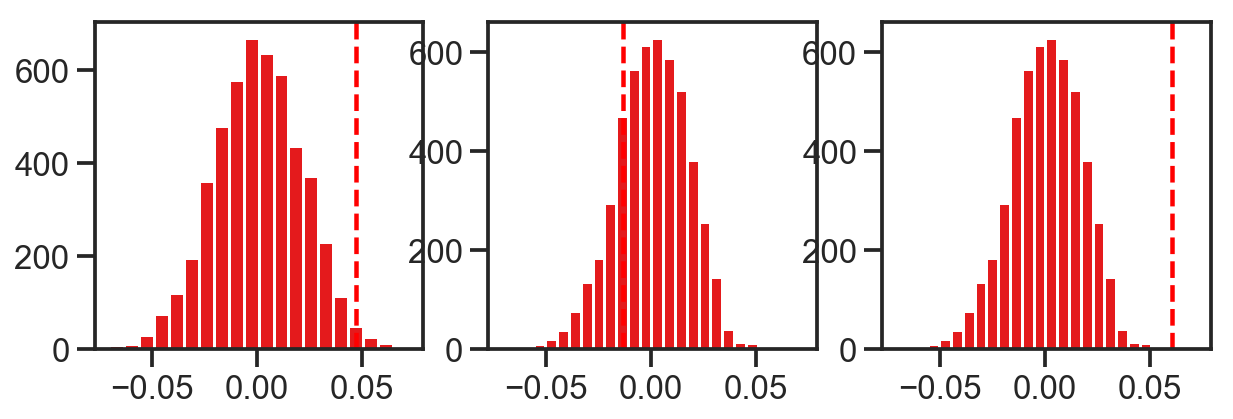

ep02 Pair-alone Subject wise permutation (SWP) r: 0.05 pval:  0.0016
ep02 Nonpair-alone Subject wise permutation (SWP) r: -0.00 pval:  0.7153
ep02 Pairs-Nonpair Subject wise permutation (SWP) r: 0.05 pval:  0.0002


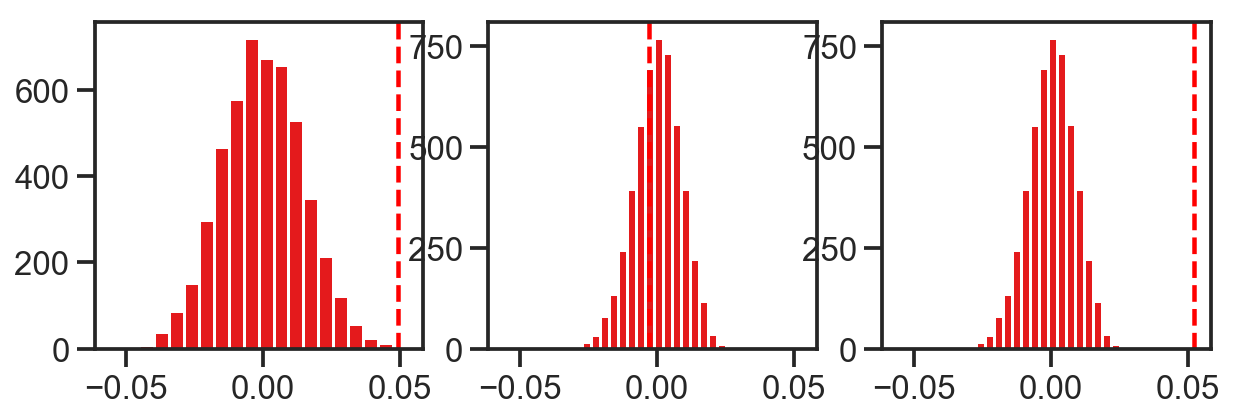

ep03 Pair-alone Subject wise permutation (SWP) r: 0.06 pval:  0.0048
ep03 Nonpair-alone Subject wise permutation (SWP) r: -0.01 pval:  0.4421
ep03 Pairs-Nonpair Subject wise permutation (SWP) r: 0.06 pval:  0.0002


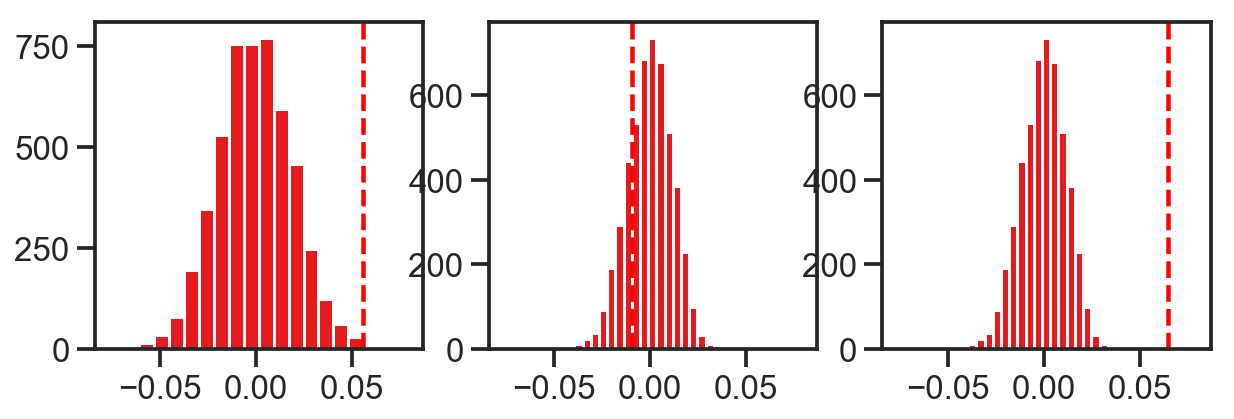

ep04 Pair-alone Subject wise permutation (SWP) r: 0.10 pval:  0.0002
ep04 Nonpair-alone Subject wise permutation (SWP) r: 0.04 pval:  0.0044
ep04 Pairs-Nonpair Subject wise permutation (SWP) r: 0.07 pval:  0.0002


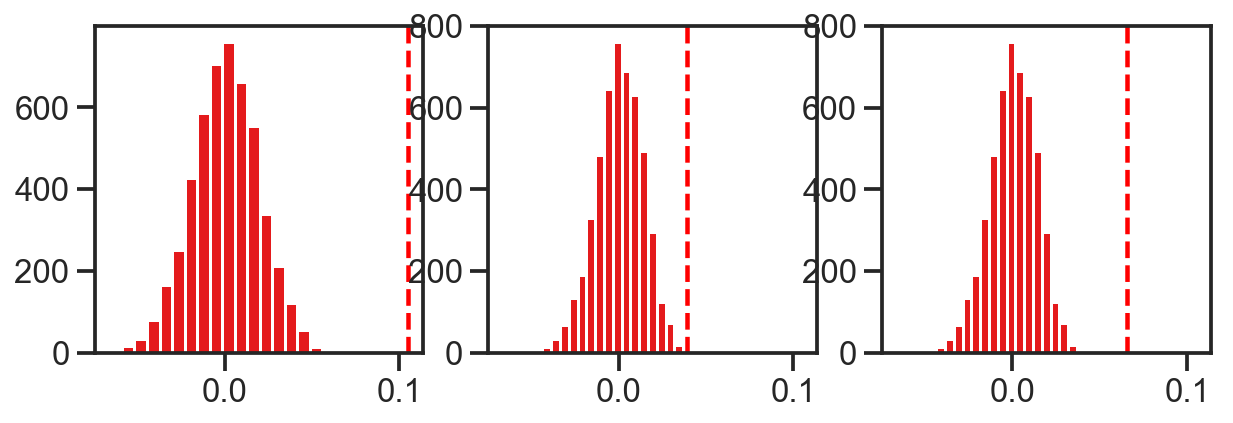

In [136]:
import nltools.stats as nlstats
# Subject wise Permutation group difference of faical expression synchrony. Reassign across groups without replacement. 
random_state=1
from sklearn.utils import check_random_state
MAX_INT = np.iinfo(np.int32).max

method = 'pearson'
winsorize=False
zscore=True
rdf, solo_r_df, dyad_r_df = load_solo_and_dyad_ts_sync(method = method, winsorize=winsorize, zscore=zscore)

for epi, epn in enumerate(['ep01','ep02','ep03','ep04']):
    # generate a combined group matrix of correlations
    fullm = pd.concat([solo_r_df[epn], dyad_r_df[epn]],axis=1).corr()
#     fullm = fullm.apply(nlstats.fisher_r_to_z) # Fisher r to z
    data = fullm.copy()
    diffs = []
    n_samples=5000
    n_jobs=-1
    random_state = check_random_state(random_state)
    seeds = random_state.randint(MAX_INT, size=n_samples)
    data_row_id = range(data.shape[0])
    diffs_pairs_alone, diffs_nonpairs_alone, diffs_pairs_nonpairs =[],[],[]
    for i in range(n_samples):
        # matrix permutation, shuffle the groups
        ix = random_state.choice(data_row_id,
                           size=len(data_row_id),
                           replace=False) 
        new_dat = data.iloc[ix,ix]
        new_dyad = new_dat.iloc[21:,21:].values
        new_alone = new_dat.iloc[:21,:21].values

        pairs = parse_triangle(new_dyad,condition='pairs').mean()
        nonpairs = parse_triangle(new_dyad,condition='nonpairs').mean()
        alone = parse_triangle(new_alone).mean()

        diffs_pairs_alone.append(pairs-alone)
        diffs_nonpairs_alone.append(nonpairs-alone)
        diffs_pairs_nonpairs.append(pairs-nonpairs)

    f,ax = plt.subplots(1,3,figsize=(10,3), sharex=True)

    # pairs - alone
    stats_mean = parse_triangle(fullm.iloc[21:,21:].values, condition='pairs').mean() - parse_triangle(fullm.iloc[:21,:21].values).mean()
    print(f'{epn} Pair-alone Subject wise permutation (SWP) r: {stats_mean:.2f} pval: ',
          np.round(nlstats._calc_pvalue(np.array(diffs_pairs_alone), stats_mean, tail = 2),4))
    ax[0].hist(diffs_pairs_alone,bins=20)
    ax[0].axvline(stats_mean,color='r',linestyle='--')
    # nonpairs-alone
    stats_mean = parse_triangle(fullm.iloc[21:,21:].values,condition='nonpairs').mean() - parse_triangle(fullm.iloc[:21,:21].values).mean()
    print(f'{epn} Nonpair-alone Subject wise permutation (SWP) r: {stats_mean:.2f} pval: ',
          np.round(nlstats._calc_pvalue(np.array(diffs_nonpairs_alone),stats_mean, tail = 2),4))
    ax[1].hist(diffs_nonpairs_alone,bins=20)
    ax[1].axvline(stats_mean,color='r',linestyle='--')
    # pairs - nonpairs
    stats_mean = parse_triangle(fullm.iloc[21:,21:].values,condition='pairs').mean() - parse_triangle(fullm.iloc[21:,21:].values,condition='nonpairs').mean()
    print(f'{epn} Pairs-Nonpair Subject wise permutation (SWP) r: {stats_mean:.2f} pval: ',
          np.round(nlstats._calc_pvalue(np.array(diffs_pairs_nonpairs),stats_mean, tail = 2),4))
    ax[2].hist(diffs_nonpairs_alone,bins=20)
    ax[2].axvline(stats_mean,color='r',linestyle='--')    
    plt.show()

# Add GSR to SEM

In [142]:
%reload_ext rpy2.ipython

In [144]:
%%R
require('lme4')
require('lmerTest')
require('lattice')
require('boot')
require('sjPlot')
require('optimx')
options("scipen"=15, "digits"=5)
r2 <- function(m) {
  lmfit <-  lm(model.response(model.frame(m)) ~ fitted(m))
#   summary(lmfit)$r.squared
  summary(lmfit)$adj.r.squared
}

In [6]:
winsorize = False
zscore = True
method = 'pearson'
dyad_data, detrended_dyad_data = load_bandpass_filtered_data(method=method, winsorize=winsorize, zscore=zscore)

combined_r_df = dyad_data.copy()
# Center episode
combined_r_df['Episode_c'] = combined_r_df.Episode.apply(lambda x: int(x[-1])-2.5)
combined_r_df['Episode_st'] = (combined_r_df.Episode_c-combined_r_df.Episode_c.mean()) /combined_r_df.Episode_c.std()

lavaan 0.6-4 ended normally after 79 iterations

  Optimization method                           NLMINB
  Number of free parameters                         17

                                                  Used       Total
  Number of observations                           110         112

  Estimator                                         ML
  Model Fit Test Statistic                       5.960
  Degrees of freedom                                 4
  P-value (Chi-square)                           0.202

Model test baseline model:

  Minimum Function Test Statistic              145.967
  Degrees of freedom                                15
  P-value                                        0.000

User model versus baseline model:

  Comparative Fit Index (CFI)                    0.985
  Tucker-Lewis Index (TLI)                       0.944

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)               -231.616
  Loglikelihood unrestricted model (H1)       -2

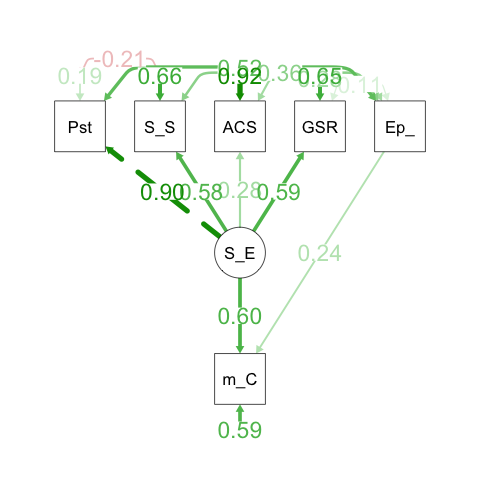

In [139]:
%%R -i combined_r_df
library(lavaan)
library(semPlot)
model <-'
          # measurement model 
          Sh_Exp =~  Positive + Spatial_SRM0 + AvgCharSim + GSRsync
          # Regression part
          mean_Connection ~ Sh_Exp + Episode_c
          # Covariance residual correlations
          Positive ~~ Spatial_SRM0 
          Episode_c ~~ Positive + Spatial_SRM0 + AvgCharSim + GSRsync
        '
fit <- sem(model, data=combined_r_df)
summary(fit, standardized=TRUE, fit.measure=TRUE)
semPaths(fit,"std", style='lisrel',layout='tree',edge.label.cex=2.0, curvePivot = TRUE, residuals=TRUE, title=TRUE,sizeMan = 10, sizeLat = 10, sizeInt = 4)
standardizedSolution(fit)
print(fitMeasures(fit,c('chisq','df','pvalue','rfi','cfi','ifi','gfi','nfi','nnfi','rmsea','rmsea.ci.lower','rmsea.ci.upper','rmsea.pvalue','srmr')))
print(inspect(fit, "sample"))
print(inspect(fit, "fitted"))
print(residuals(fit, type="cor"))



In [153]:
#  Demeaned
combined_r_df['Positive_dm']=combined_r_df.Positive-combined_r_df.Positive.mean()
combined_r_df['Negative_dm']=combined_r_df.Negative-combined_r_df.Negative.mean()
combined_r_df['mean_Enjoy_dm']=combined_r_df.mean_Enjoy-combined_r_df.mean_Enjoy.mean()
combined_r_df['ImpSim_dm']=combined_r_df.ImpSim-combined_r_df.ImpSim.mean()
combined_r_df['AvgCharSim_dm']=combined_r_df.AvgCharSim-combined_r_df.AvgCharSim.mean()
combined_r_df['GSRsync_dm']=combined_r_df.GSRsync-combined_r_df.GSRsync.mean()
combined_r_df['AverageAUSim_dm']=combined_r_df.AverageAUSim-combined_r_df.AverageAUSim.mean()
combined_r_df['Spatial_SRM0_dm']=combined_r_df.Spatial_SRM0-combined_r_df.Spatial_SRM0.mean()
combined_r_df['Spatial_SRM1_dm']=combined_r_df.Spatial_SRM1-combined_r_df.Spatial_SRM1.mean()
combined_r_df['Temporal_SRM0_dm']=combined_r_df.Temporal_SRM0-combined_r_df.Temporal_SRM0.mean()
combined_r_df['Temporal_SRM1_dm']=combined_r_df.Temporal_SRM1-combined_r_df.Temporal_SRM1.mean()
# # Standardized
combined_r_df['Positive_st']=(combined_r_df.Positive-combined_r_df.Positive.mean() )/ combined_r_df.Positive.std()
combined_r_df['Negative_st']=(combined_r_df.Negative-combined_r_df.Negative.mean()) /combined_r_df.Negative.std() 
combined_r_df['mean_Enjoy_st']=(combined_r_df.mean_Enjoy-combined_r_df.mean_Enjoy.mean()) /combined_r_df.mean_Enjoy.std() 
combined_r_df['ImpSim_st']=(combined_r_df.ImpSim-combined_r_df.ImpSim.mean() )/ combined_r_df.ImpSim.std()
combined_r_df['AverageAUSim_st']=(combined_r_df.AverageAUSim-combined_r_df.AverageAUSim.mean()) /combined_r_df.AverageAUSim.std()
combined_r_df['Spatial_SRM0_st']=(combined_r_df.Spatial_SRM0-combined_r_df.Spatial_SRM0.mean())/combined_r_df.Spatial_SRM0.std()
combined_r_df['Spatial_SRM1_st']=(combined_r_df.Spatial_SRM1-combined_r_df.Spatial_SRM1.mean())/combined_r_df.Spatial_SRM1.std()
combined_r_df['Temporal_SRM0_st']=(combined_r_df.Temporal_SRM0-combined_r_df.Temporal_SRM0.mean())/combined_r_df.Temporal_SRM0.std()
combined_r_df['Temporal_SRM1_st']=(combined_r_df.Temporal_SRM1-combined_r_df.Temporal_SRM1.mean())/combined_r_df.Temporal_SRM1.std()

In [141]:
%%R -i combined_r_df
m <- lmer('mean_Connection ~ Positive_dm * Episode_c + (1|dyadID)', data=combined_r_df)
print(coef(summary(m)))
m <- lmer('mean_Connection ~ Spatial_SRM0_dm * Episode_c  +(1|dyadID)', data=combined_r_df)
print(coef(summary(m)))
m <- lmer('mean_Connection ~ AvgCharSim_dm * Episode_c  +(1|dyadID)', data=combined_r_df)
print(coef(summary(m)))
m <- lmer('mean_Connection ~ mean_Enjoy_dm * Episode_c  +(1|dyadID)', data=combined_r_df)
print(coef(summary(m)))

                      Estimate Std. Error     df t value             Pr(>|t|)
(Intercept)            3.97107   0.270539 26.076 14.6783 0.000000000000040574
Positive_dm            1.04450   0.310792 87.760  3.3608 0.001152378142336323
Episode_c              0.24891   0.041095 81.062  6.0571 0.000000041363738694
Positive_dm:Episode_c  0.38441   0.178216 80.689  2.1570 0.033983627814916102
                          Estimate Std. Error     df  t value
(Intercept)               3.991875   0.291337 26.915 13.70192
Spatial_SRM0_dm           0.277276   0.150010 82.570  1.84838
Episode_c                 0.285975   0.042718 80.987  6.69444
Spatial_SRM0_dm:Episode_c 0.014031   0.116060 81.448  0.12089
                                     Pr(>|t|)
(Intercept)               0.00000000000011874
Spatial_SRM0_dm           0.06812718816818175
Episode_c                 0.00000000260708096
Spatial_SRM0_dm:Episode_c 0.90407455610824394
                        Estimate Std. Error     df t value           P

In [142]:
%%R -i combined_r_df
m <- lmer('mean_Connection ~ GSRsync_dm * Episode_c  +(1|dyadID)', data=combined_r_df)
print(coef(summary(m)))

                     Estimate Std. Error     df  t value             Pr(>|t|)
(Intercept)           3.99715   0.286242 26.922 13.96424 0.000000000000075411
GSRsync_dm            1.87294   0.470024 81.173  3.98479 0.000146662361234107
Episode_c             0.29494   0.038466 79.074  7.66746 0.000000000038440209
GSRsync_dm:Episode_c  0.11491   0.355874 79.906  0.32288 0.747627729925209206


# Group difference using lmer

In [144]:
# prepare dataframe.
method = 'pearson'
winsorize=False
zscore=True
rdf, solo_r_df, dyad_r_df = load_solo_and_dyad_ts_sync(method = method, winsorize=winsorize, zscore=zscore)

lmer_df = rdf.query('Condition!="DyadNP"') # Alone, Dyad, DyadNP
lmer_df['Episode_c'] = lmer_df['Episode'].apply(lambda x: int(x[-1])-2.5)
_lmer_df = lmer_df.copy()
_lmer_df['Sub1'] = lmer_df['Sub2']
_lmer_df['Sub2'] = lmer_df['Sub1']
lmer_df = pd.concat([lmer_df,_lmer_df],axis=0).reset_index(drop=True)

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [145]:
%%R -i lmer_df

library(lmerTest)
lmer_df$Sub1 <- as.factor(lmer_df$Sub1)
lmer_df$Sub2 <- as.factor(lmer_df$Sub2)
lmer_df$Condition <- as.factor(lmer_df$Condition)
contrasts(lmer_df$Condition)<-c(-.5,.5)
# Dyad - Alone
m <- lmer('Synchrony ~ Condition * Episode_c + (1 + Episode_c|Sub1) + (1 + Episode_c|Sub2)', data = lmer_df, 
          control = lmerControl(optimizer ="Nelder_Mead"))
# Alone - DyadNP
# m <- lmer('Synchrony ~ Condition * Episode_c + (1+Episode_c|Sub1) + (1+Episode_c|Sub2)', data = pos_df, 
#           control = lmerControl(optimizer ="Nelder_Mead"))
# For Dyad - DyadNP
# m <- lmer('Synchrony ~ Condition + Episode_c + (1 + Condition|Sub1) + (1 + Condition|Sub2)', data = pos_df, 
#           control = lmerControl(optimizer ="Nelder_Mead"))
summary(m)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"Synchrony ~ Condition * Episode_c + (1 + Episode_c|Sub1) + (1 + Episode_c|Sub2)"
   Data: lmer_df
Control: lmerControl(optimizer = "Nelder_Mead")

REML criterion at convergence: -3931.7

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-2.952 -0.664 -0.114  0.538  7.020 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 Sub1     (Intercept) 0.000474 0.0218        
          Episode_c   0.000161 0.0127   -0.79
 Sub2     (Intercept) 0.001495 0.0387        
          Episode_c   0.000341 0.0185   -0.91
 Residual             0.006761 0.0822        
Number of obs: 1924, groups:  Sub1, 85; Sub2, 85

Fixed effects:
                      Estimate Std. Error        df t value         Pr(>|t|)
(Intercept)           0.071227   0.006255 35.982542   11.39 0.00000000000017
Condition1            0.063737   0.012511 35.982542    5.09 0.00001125947270
Episode_c             0.000295   0.0

In [116]:
tt = 1.54
n = 40.42/2
pval = stats.t.sf(np.abs(tt), n-1)*2 
print(pval, n)

0.13987138399039123 20.21
